# BE/Bi 103, Fall 2016: Homework 5
## Due 1pm, Sunday, October 30

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw5_solutions.ipynb).*

In [14]:
import collections
import glob
import os

import numpy as np
import numba
import pandas as pd
import sklearn.neighbors
import sklearn.preprocessing
import scipy.stats as st
import skimage.filters
import matplotlib.path
import matplotlib._cntr

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

import emcee
import corner

import bebi103

# Make Matplotlib plots appear inline
%matplotlib inline

### Problem 5.1: Outliers in FRET binding curve (20 pts)

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, $a$ and $b$ may bind to each other in the reaction

\begin{align}
ab \rightleftharpoons a + b
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of $a$ and $b$ to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed and measure $c_{ab}$ for various $c_b^0$.  We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$.  For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of $a$ is bound to $b$.  Specifically, we consider $a$ to have a fluorophore and $b$ to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume.  We define by $e$ the FRET efficiency,

\begin{align}
e = 1 - \frac{f}{f_0}.
\end{align}

If we measure $F_0$, the measured fluorescence when there is no b protein in the sample, we can compute the FRET efficiency from  the measured values $F$ and $F_0$

\begin{align}
e =  1 - \frac{c_a^0\,V f}{c_a^0\,Vf_0} = 1 - \frac{F}{F_0}.
\end{align}

Substituting in our expressions for $F$ and $F_0$, we get

\begin{align}
e = 1 - \frac{\left(c_a \,f_0 + c_{ab}\, f_q\right)V}{c_a^0\,V f_0}
= 1 - \frac{c_a}{c_a^0} - \frac{c_{ab}}{c_a^0}\,\frac{f_q}{f_0}.
\end{align}

Using the fact that $c_a^0 = c_a + c_{ab}$, this becomes

\begin{align}
e = \left(1-\frac{f_q}{f_0}\right)\frac{c_{ab}}{c_a^0}.
\end{align}

In other words, the FRET efficiency is proportional to the fraction of a that is bound, or

\begin{align}
e = \alpha \, \frac{c_{ab}}{c_a^0} = \frac{2\alpha\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}},
\end{align}

where $\alpha = 1-f_q/f_0$.  So, we perform a regression with two phenomenological parameters to fit, $\alpha$ and $K_d$.  Note that $0 \le \alpha \le 1$.

**a)** Load in the data for one of these FRET efficiency titration curves.  You can download the data set [here](http://bebi103.caltech.edu/2016/data/fret_binding_curve.csv).  Compute the background-subtracted fluorescence and the FRET efficiency.  *These are real data, but they are from an unpublished experiment here on campus.  If you are interested in the proteins we are studying, please ask me and we can discuss.*

**b)** Perform regressions to find $K_d$ with and without an outlier detection scheme. You should present the results of your regression both graphically and with numerical summaries (e.g., mode with HPD). How do the results differ depending on whether or not you were trying to detect outliers?

### Problem 5.1: solution



### Problem 5.2: solution

First, we'll load in the data, and look at the `DataFrame`.

In [15]:
df = pd.read_csv('../data/fret_binding_curve.csv', comment='#')
df.head()

buffer  fluorescence  a conc (nM)  b conc (nM)
0  1256.5751   258316.2818         50.0      1500.00
1  1256.5751   267722.6277         50.0       750.00
2  1256.5751   267431.6620         50.0       375.00
3  1256.5751   284596.2914         50.0       187.50
4  1256.5751   254903.3958         50.0        93.75

To compute the background subtracted fluorescence, we simply subtract the `'buffer'` column from the `'fluorescence'` column.  Then, to compute the FRET efficiency, we divide each background subtracted fluorescence by that with $c_b^0 = 0$.

In [16]:
# Subtract background
df['bg_sub_fluor'] = df['fluorescence'] - df['buffer']

# Compute FRET efficiency (import. use .values in denom b/c of indexing issues)
df['FRET efficiency'] = 1 - df['bg_sub_fluor'] \
                                / df[df['b conc (nM)']==0]['bg_sub_fluor'].values

# Pull out parameters for curve fit
inds = df['b conc (nM)'] > 0
ca0 = df[inds]['a conc (nM)'].values
cb0 = df[inds]['b conc (nM)'].values
e = df[inds]['FRET efficiency'].values

Let's plot the data, FRET efficiency vs. $c_b^0$.

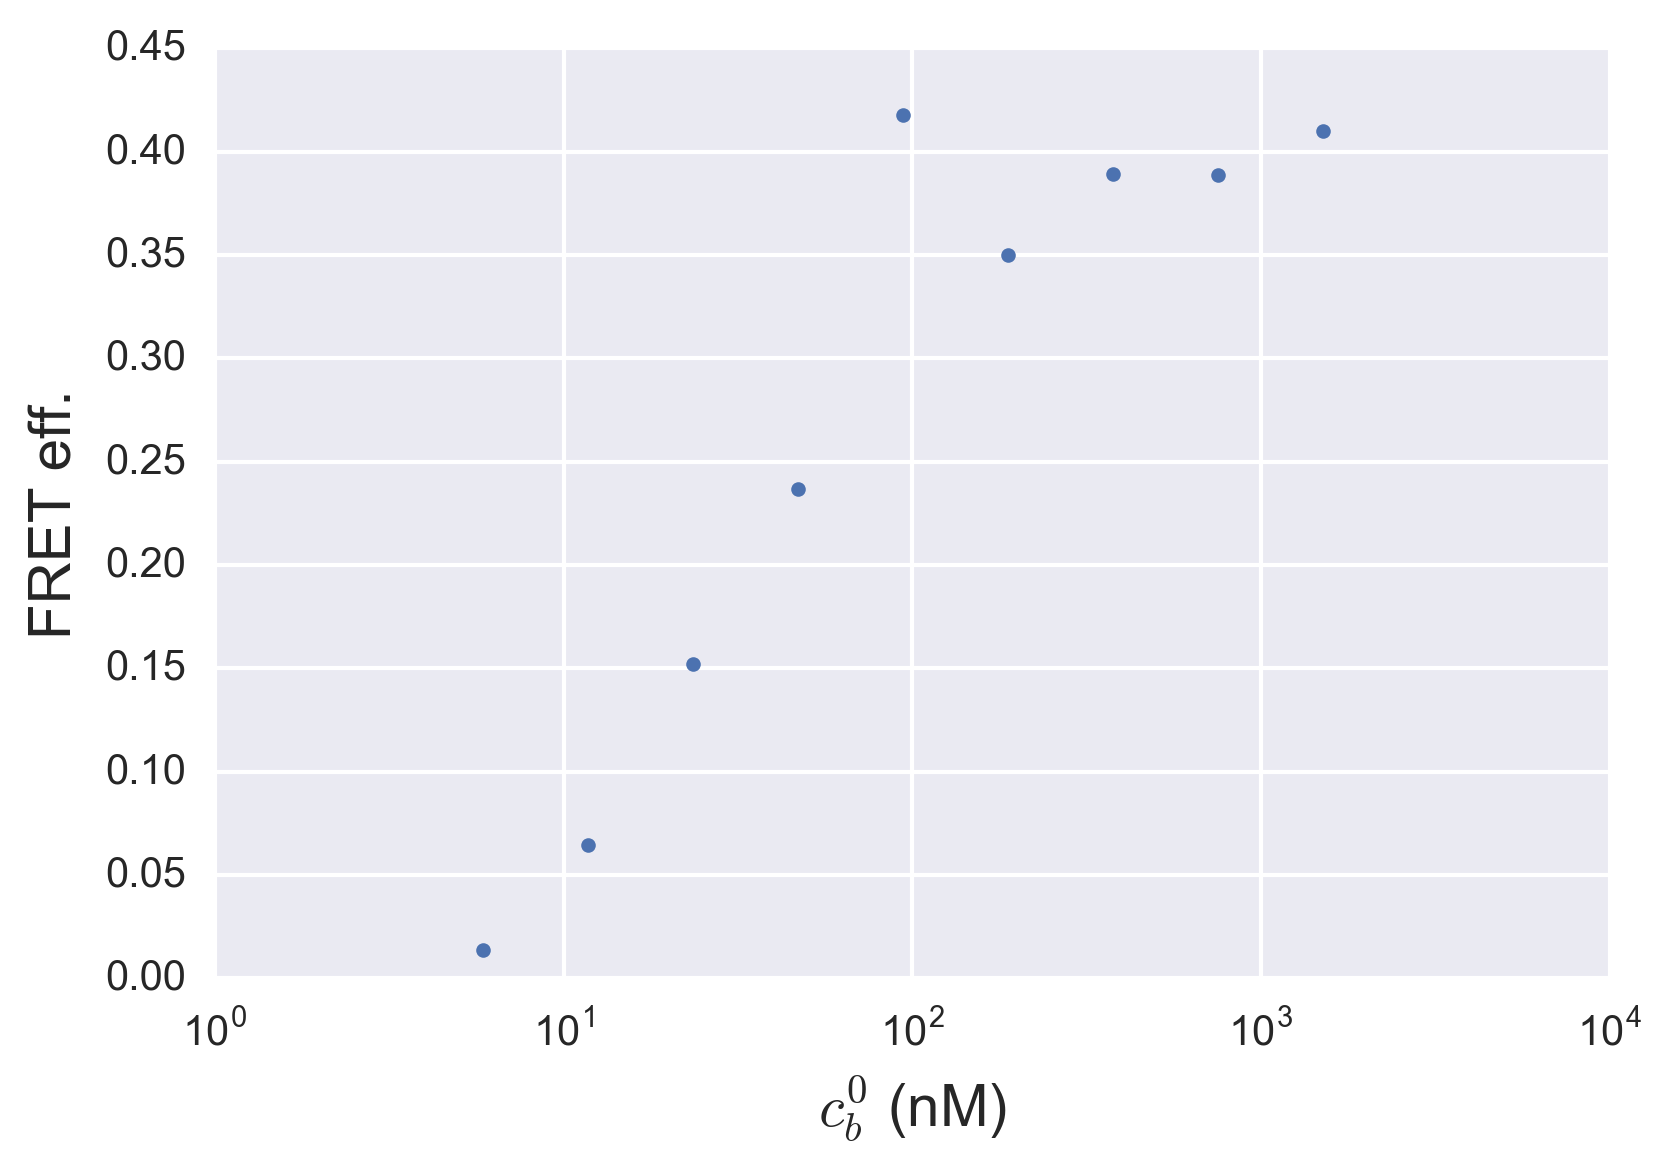

In [18]:
plt.semilogx(cb0, e, '.')
plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.');

We are sampling the dynamic part of the titration curve, which is good, but we do seem to have a clear outlier.

**b)** Before we can perform the curve fits, we need to write a function for the theoretical FRET efficiency.  First, we'll write a function for the fraction of species a (the donor) that is bound.  We'll then use that to compute the FRET efficiency.  We will use the free energy $\Delta G$ as our parameter to allow for uniform priors and simpler numerics.

In [19]:
@numba.jit(nopython=True)
def fraction_bound(Kd, ca0, cb0):
    """
    Fraction of species a that is bound to b.
    """
    b = Kd + ca0 + cb0
    return 2 * cb0 / (b + np.sqrt(b**2 - 4 * ca0 * cb0))


@numba.jit(nopython=True)
def fret_efficiency(p, ca0, cb0):
    """
    Compute FRET efficiency.  p = [delta_G, alpha, sigma], where
    Kd = exp(-delta_G).
    """
    delta_G, alpha, _ = p
    return alpha * fraction_bound(np.exp(-delta_G), ca0, cb0)

For fitting the data without consideration for outliers, we will use the standard Gaussian likelihood.  To consider outliers, we use a Cauchy likelihood.  Can can code up the log likelihood, prior, and posterior.

In [26]:
@numba.jit(nopython=True)
def log_prior(p, p_range):
    """
    Log of the prior with p = np.array([delta_G, alpha, sigma]).
    
    p_range = np.array([[delta_G_min, delta_G_max], 
                        [alpha_min,   alpha_max],
                        [sigma_min,   sigma_max]])  
                        
    Substitute beta for sigma if using Cauchy likelihood.
    """
    if (p < p_range[:,0]).any() or (p > p_range[:,1]).any():
        return -np.inf
    
    return -np.log(p_range[:2,1] - p_range[:2,0]).sum() \
                - np.log(np.log(p_range[2,1] / p_range[2,0]) * p[2])

    
@numba.jit(nopython=True)
def log_likelihood(p, cb0, e, ca0, cauchy=False):
    """
    Log likelihood for dissociation measured by FRET efficiency with
    p = np.array([delta_G, alpha, sigma]) or np.array([delta_G, alpha, beta])
    """

    if cauchy:
        return -len(cb0) * np.log(p[2]) \
            - np.sum(np.log(1 + ((e - fret_efficiency(p, ca0, cb0))/ p[2])**2))
    else:
        return -np.sum((e - fret_efficiency(p, ca0, cb0))**2) / 2 / p[2]**2 \
                    - len(cb0) / 2 * np.log(2 * np.pi * p[2]**2)


def log_posterior(p, cb0, e, ca0, p_range, cauchy=False):
    """
    Log posterior for either Gausisan or Cauchy
    """
    lp = log_prior(p, p_range)
    if lp == -np.inf:
        return -np.inf

    return log_likelihood(p, cb0, e, ca0, cauchy=cauchy) + lp


def neg_log_posterior(p, cb0, e, ca0, p_range, cauchy=False):
    return -log_posterior(p, cb0, e, ca0, p_range, cauchy=False)

Because we are only doing a single curve fit and we would like to have information about the posterior, we will use MCMC to do the regression.  First, we'll use a Gaussian likelihood.

In [33]:
# Range of parameter values
p_range = np.array([[-20, 20],
                    [0, 1],
                    [1e-4, 1]])

# Arguments to pass to log posterior
args = (cb0, e, ca0, p_range, False)

# Parameters and how we start them
p_dict = collections.OrderedDict([('delta_G', (np.random.uniform, (-3, 3))),
                                  ('alpha', (np.random.uniform, (0, 1))),
                                  ('sigma', (np.random.uniform, (0.01, 0.5)))])

# Define walker settings
n_walkers = 50
n_burn = 10000
n_steps = 10000

df_mcmc_gauss = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, 
                                           n_walkers=n_walkers, p_dict=p_dict, 
                                           args=args, threads=6)

We can compute $K_d$ from our samples.

In [34]:
df_mcmc_gauss['Kd'] = np.exp(-df_mcmc_gauss['delta_G'])

Now we can make a corner plot.  We will not put labels on the units in the plot, but note that $\Delta G$ is in some weird units such that when it is exponentiated, the result has units of $K_d$, which are nanomolar.  $\alpha$ and $\sigma$ are dimensionless.

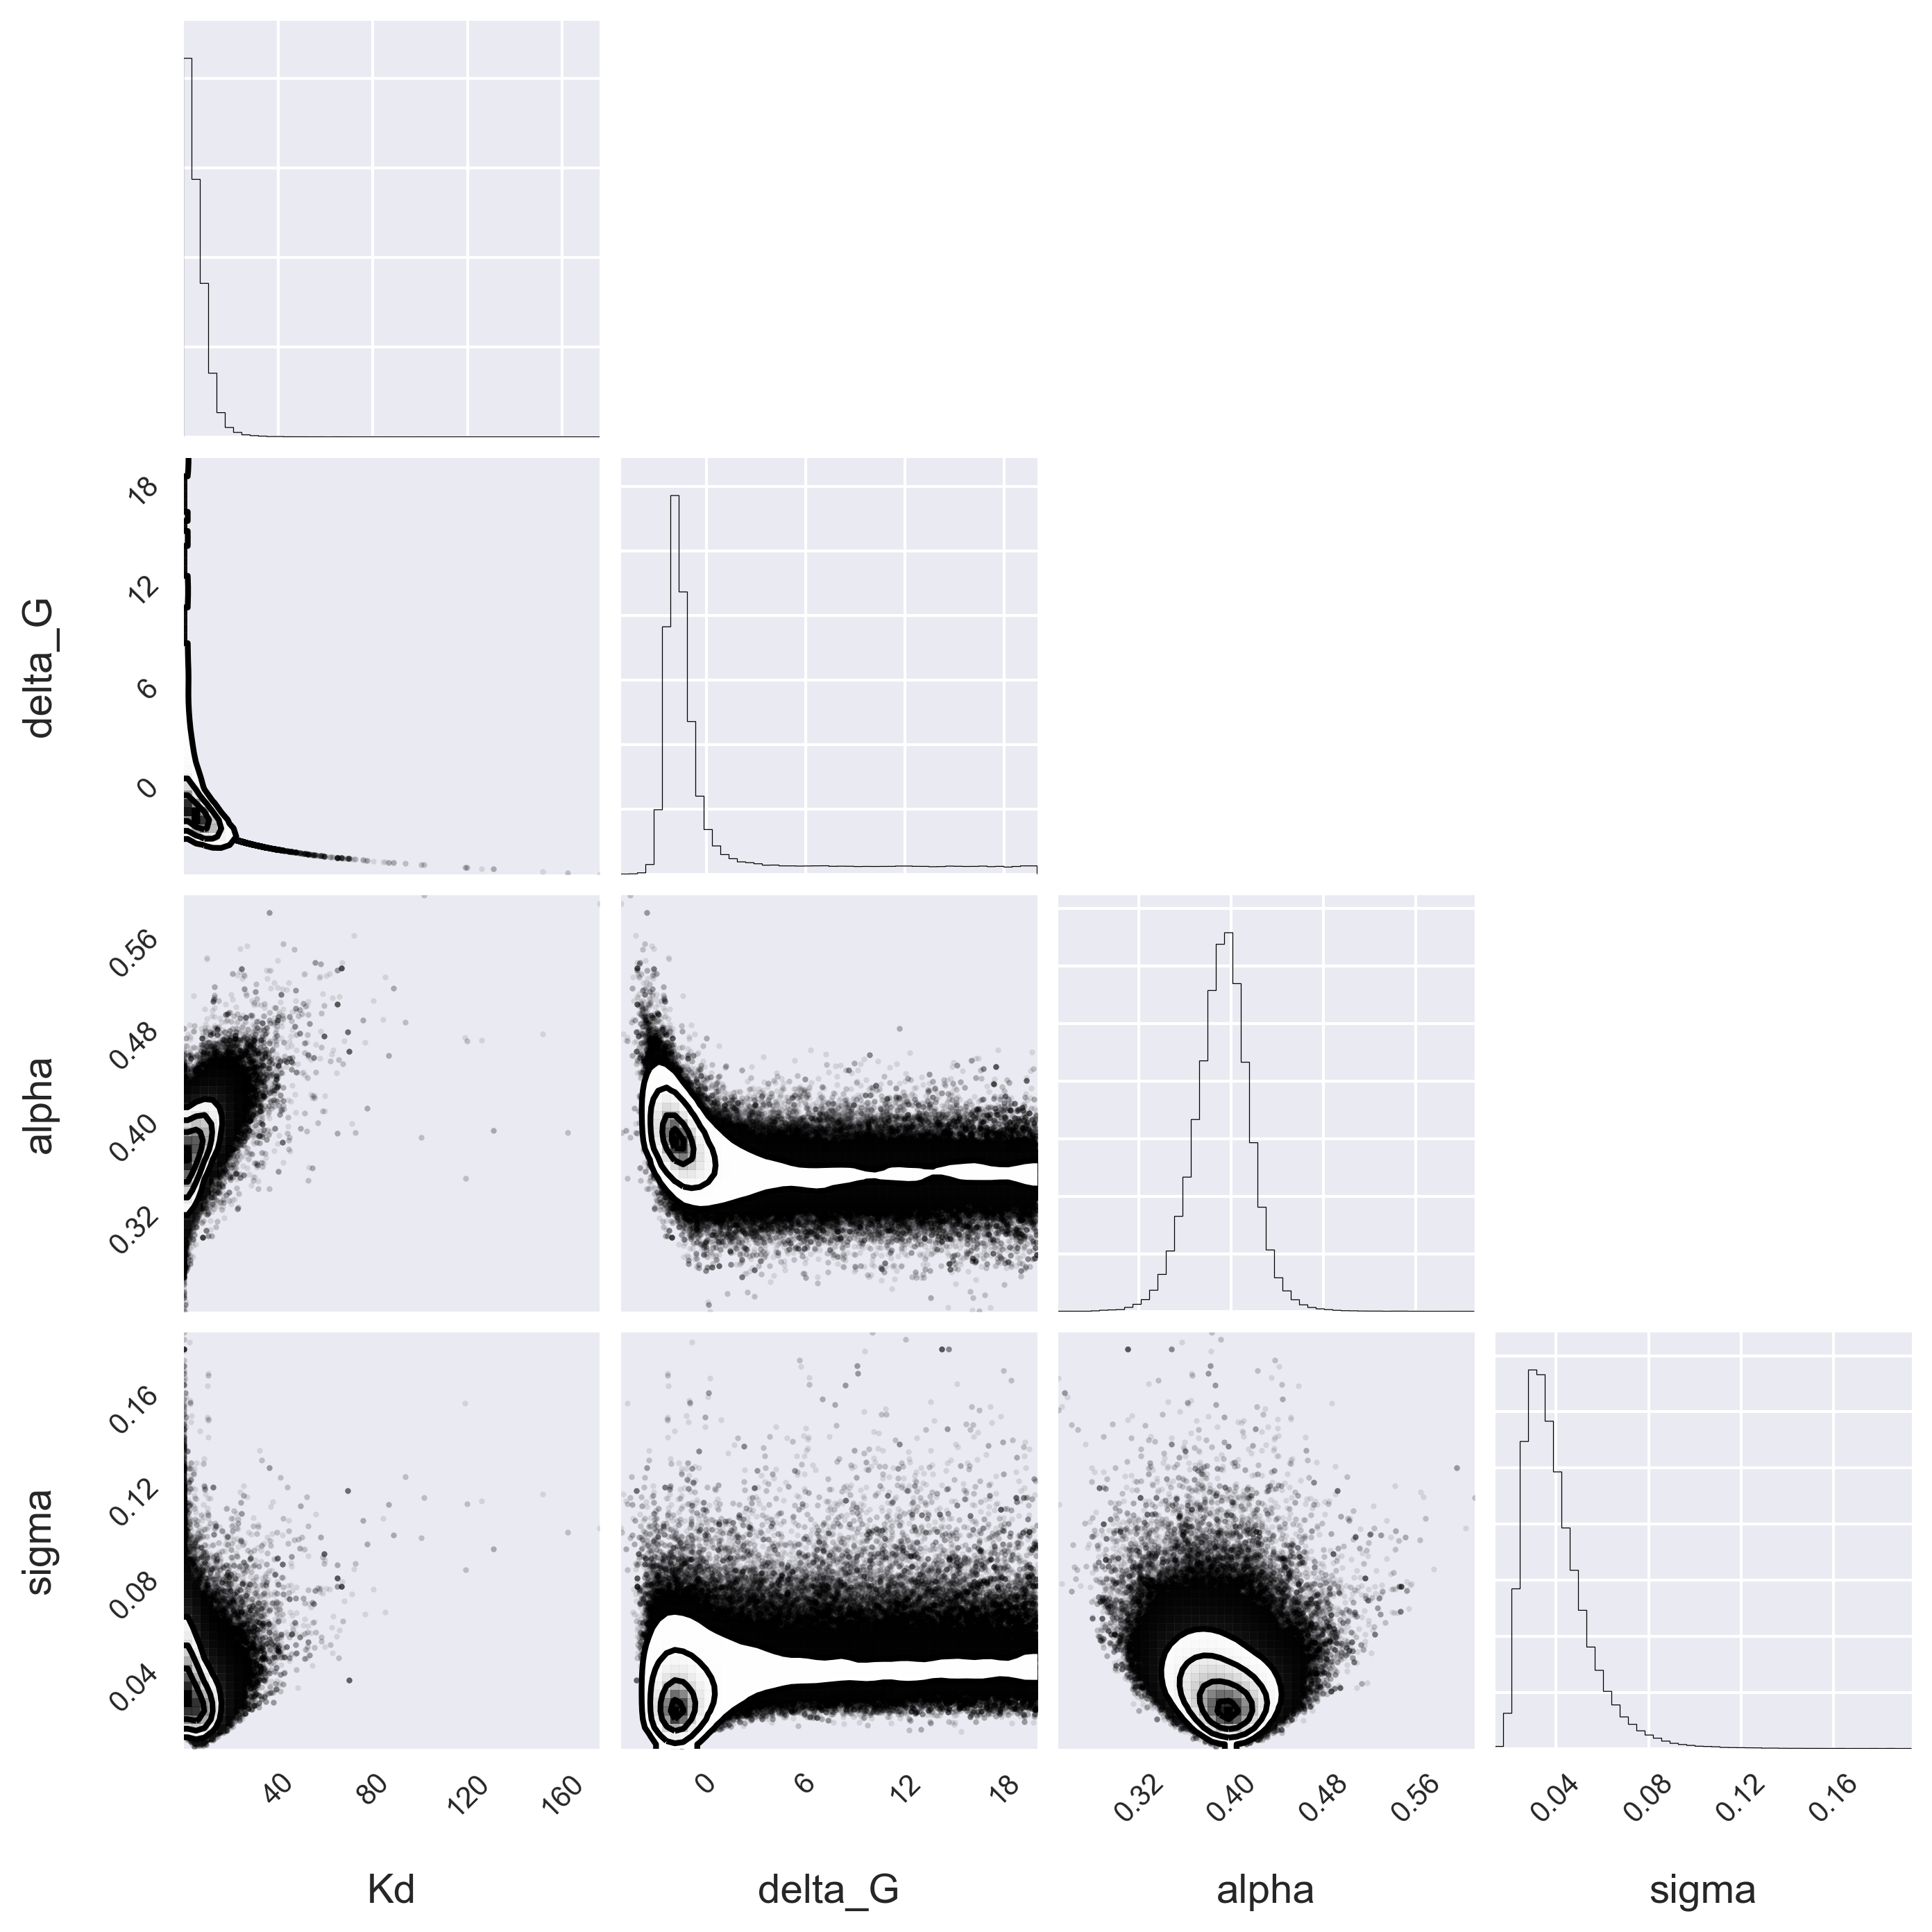

In [35]:
corner.corner(df_mcmc_gauss[['Kd', 'delta_G', 'alpha', 'sigma']], bins=50,
              smooth=1);

We see that we know pretty well that $\alpha \approx 0.4$.  We see a long tail on $\Delta G$, though, likely due to the presence of the outlier.  Let's now report the results for $K_d$ and $\alpha$ as a mode with HPD containing 68% of the posterior probability.

In [36]:
# Compute HPD for Kd (must be using what was actually sampled)
map_ind = np.argmax(df_mcmc_gauss['lnprob'])
delta_G_mode = df_mcmc_gauss['delta_G'].iloc[map_ind]
delta_G_hpd = bebi103.hpd(df_mcmc_gauss['delta_G'].values, 0.68)
Kd_mode = np.exp(-delta_G_mode)
Kd_hpd = np.exp(-delta_G_hpd)

# Compute HPD for alpha
alpha_mode = df_mcmc_gauss['alpha'].iloc[map_ind]
alpha_hpd = bebi103.hpd(df_mcmc_gauss['alpha'].values, 0.68)

print("""
ΔG = [{1:.2f}   {0:.2f}    {2:.2f}]  in weird units
Kd = [{4:.2e}   {3:.2e}    {5:.2e}]  nM
α =  [{7:.3f}   {6:.3f}    {8:.3f}]
""".format(delta_G_mode, delta_G_hpd[0], delta_G_hpd[1],
           Kd_mode, Kd_hpd[1], Kd_hpd[0], 
           alpha_mode, alpha_hpd[0], alpha_hpd[1]))


ΔG = [-2.75   -1.90    -0.56]  in weird units
Kd = [1.76e+00   6.66e+00    1.56e+01]  nM
α =  [0.371   0.400    0.416]



Because of the long tail in the marginalized posterior for $\Delta G$, we can get exceptionally low $K_d$ values.  This is due to the influence of the outlier, which pulls the best-fit theoretical curve upward.

Let's look at the best fit curve overlayed with the data.

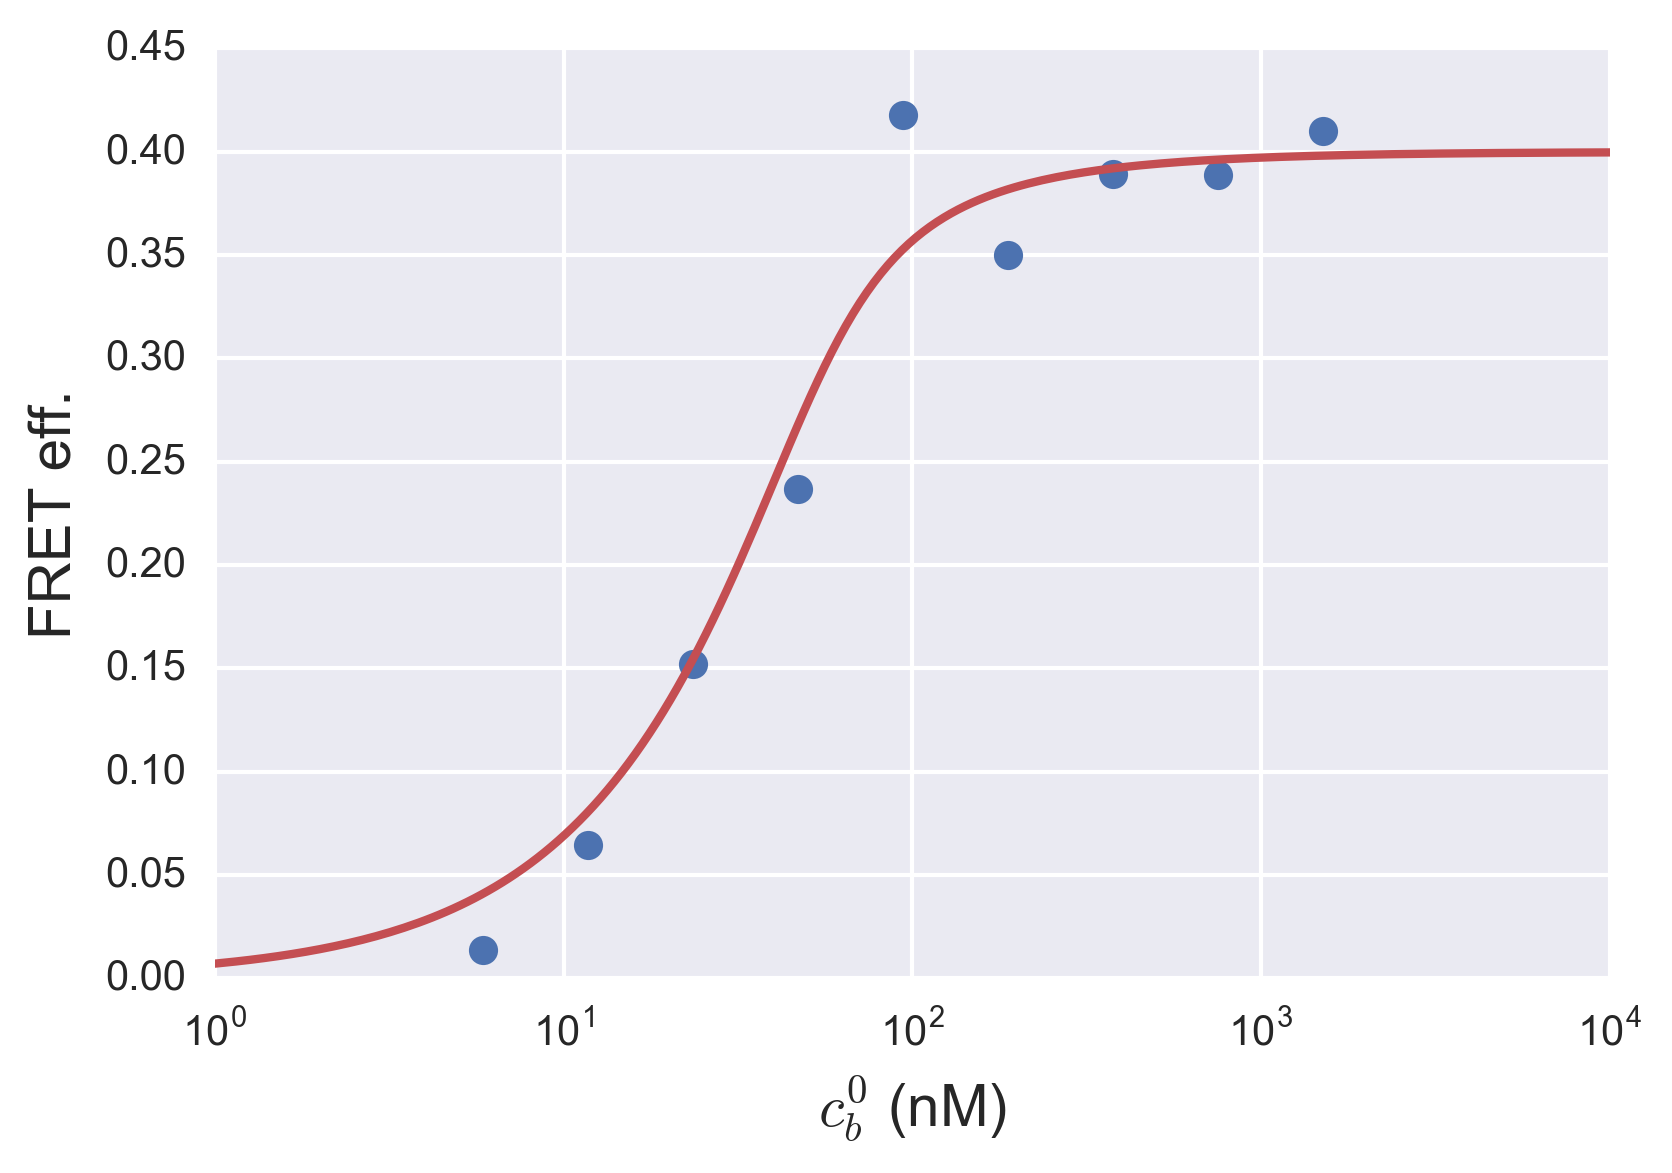

In [37]:
# Generate smooth curve
cb0_smooth = np.logspace(0, 4, 200)
p = np.array([delta_G_mode, alpha_mode, df_mcmc_gauss['sigma'].iloc[map_ind]])
e_smooth = fret_efficiency(p, ca0[0], cb0_smooth)

# Make the plot
plt.semilogx(cb0, e, 'o')
plt.semilogx(cb0_smooth, e_smooth, '-', color=sns.color_palette()[2])
plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.');

Perhaps more informative is a plot where we include the theoretical curves from many of our samples.  We'll pick 1000 random samples and plot those.

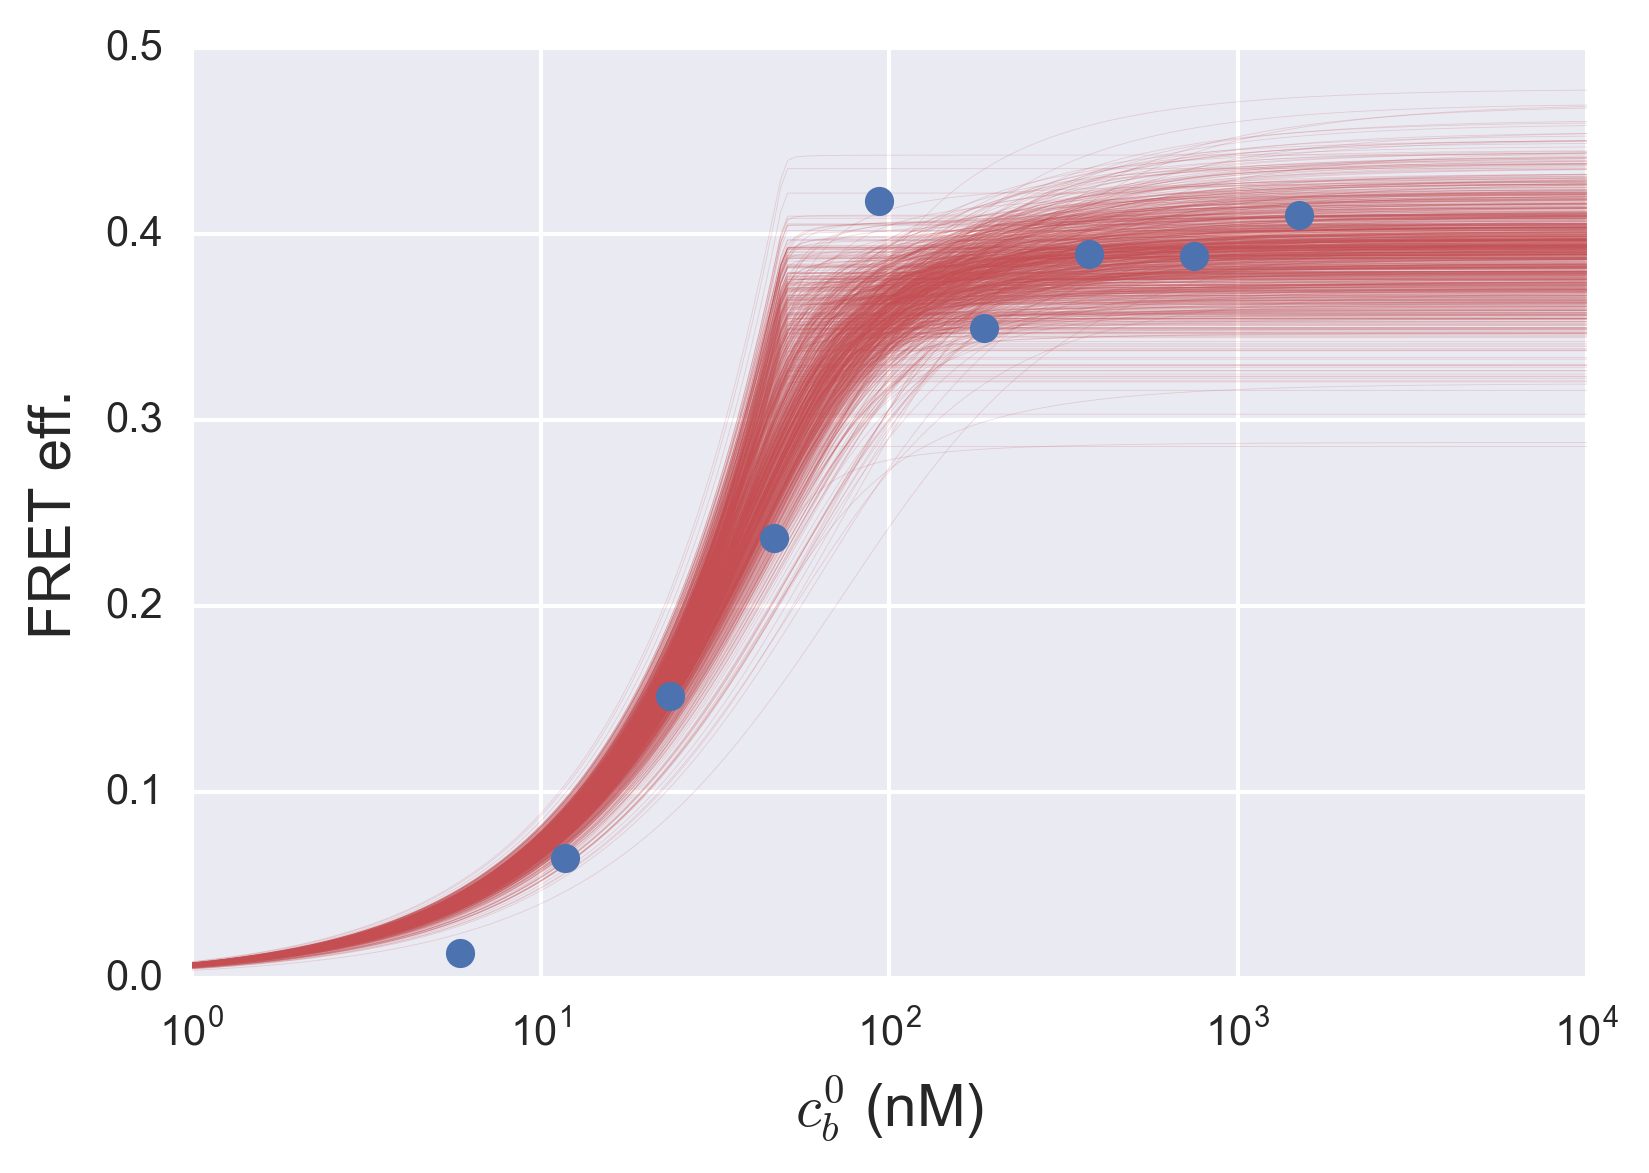

In [38]:
# Which parameter samples to make smooth curves out of
sample_inds = np.random.choice(np.arange(len(df_mcmc_gauss), dtype=int), 1000)

# Smooth x-values
cb0_smooth = np.logspace(0, 4, 200)
# Make the plot
plt.semilogx(cb0, e, 'o', zorder=2)

for ind in sample_inds:
    p = df_mcmc_gauss[['delta_G', 'alpha', 'sigma']].iloc[ind].values
    e_smooth = fret_efficiency(p, ca0[0], cb0_smooth)
    plt.semilogx(cb0_smooth, e_smooth, '-', color=sns.color_palette()[2],
                 lw=0.2, alpha=0.2, zorder=1)

plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.');

Now, let's repeat the analysis using a Cauchy likelihood, which will mitigate the pull of the outlier.  First, we'll run MCMC to get the samples

In [40]:
# Range of parameter values
p_range = np.array([[-20, 20],
                    [0, 1],
                    [1e-4, 1]])

# Arguments to pass to log posterior
args = (cb0, e, ca0, p_range, True)

# Parameters and how we start them
p_dict = collections.OrderedDict([('delta_G', (np.random.uniform, (-3, 3))),
                                  ('alpha', (np.random.uniform, (0, 1))),
                                  ('beta', (np.random.uniform, (0.01, 0.5)))])

# Define walker settings
n_walkers = 50
n_burn = 5000
n_steps = 5000

df_mcmc_cauchy = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, 
                                            n_walkers=n_walkers, p_dict=p_dict, 
                                            args=args, threads=6)

# Compute K_d
df_mcmc_cauchy['Kd'] = np.exp(-df_mcmc_cauchy['delta_G'])

Let's take a look at a nice corner plot.

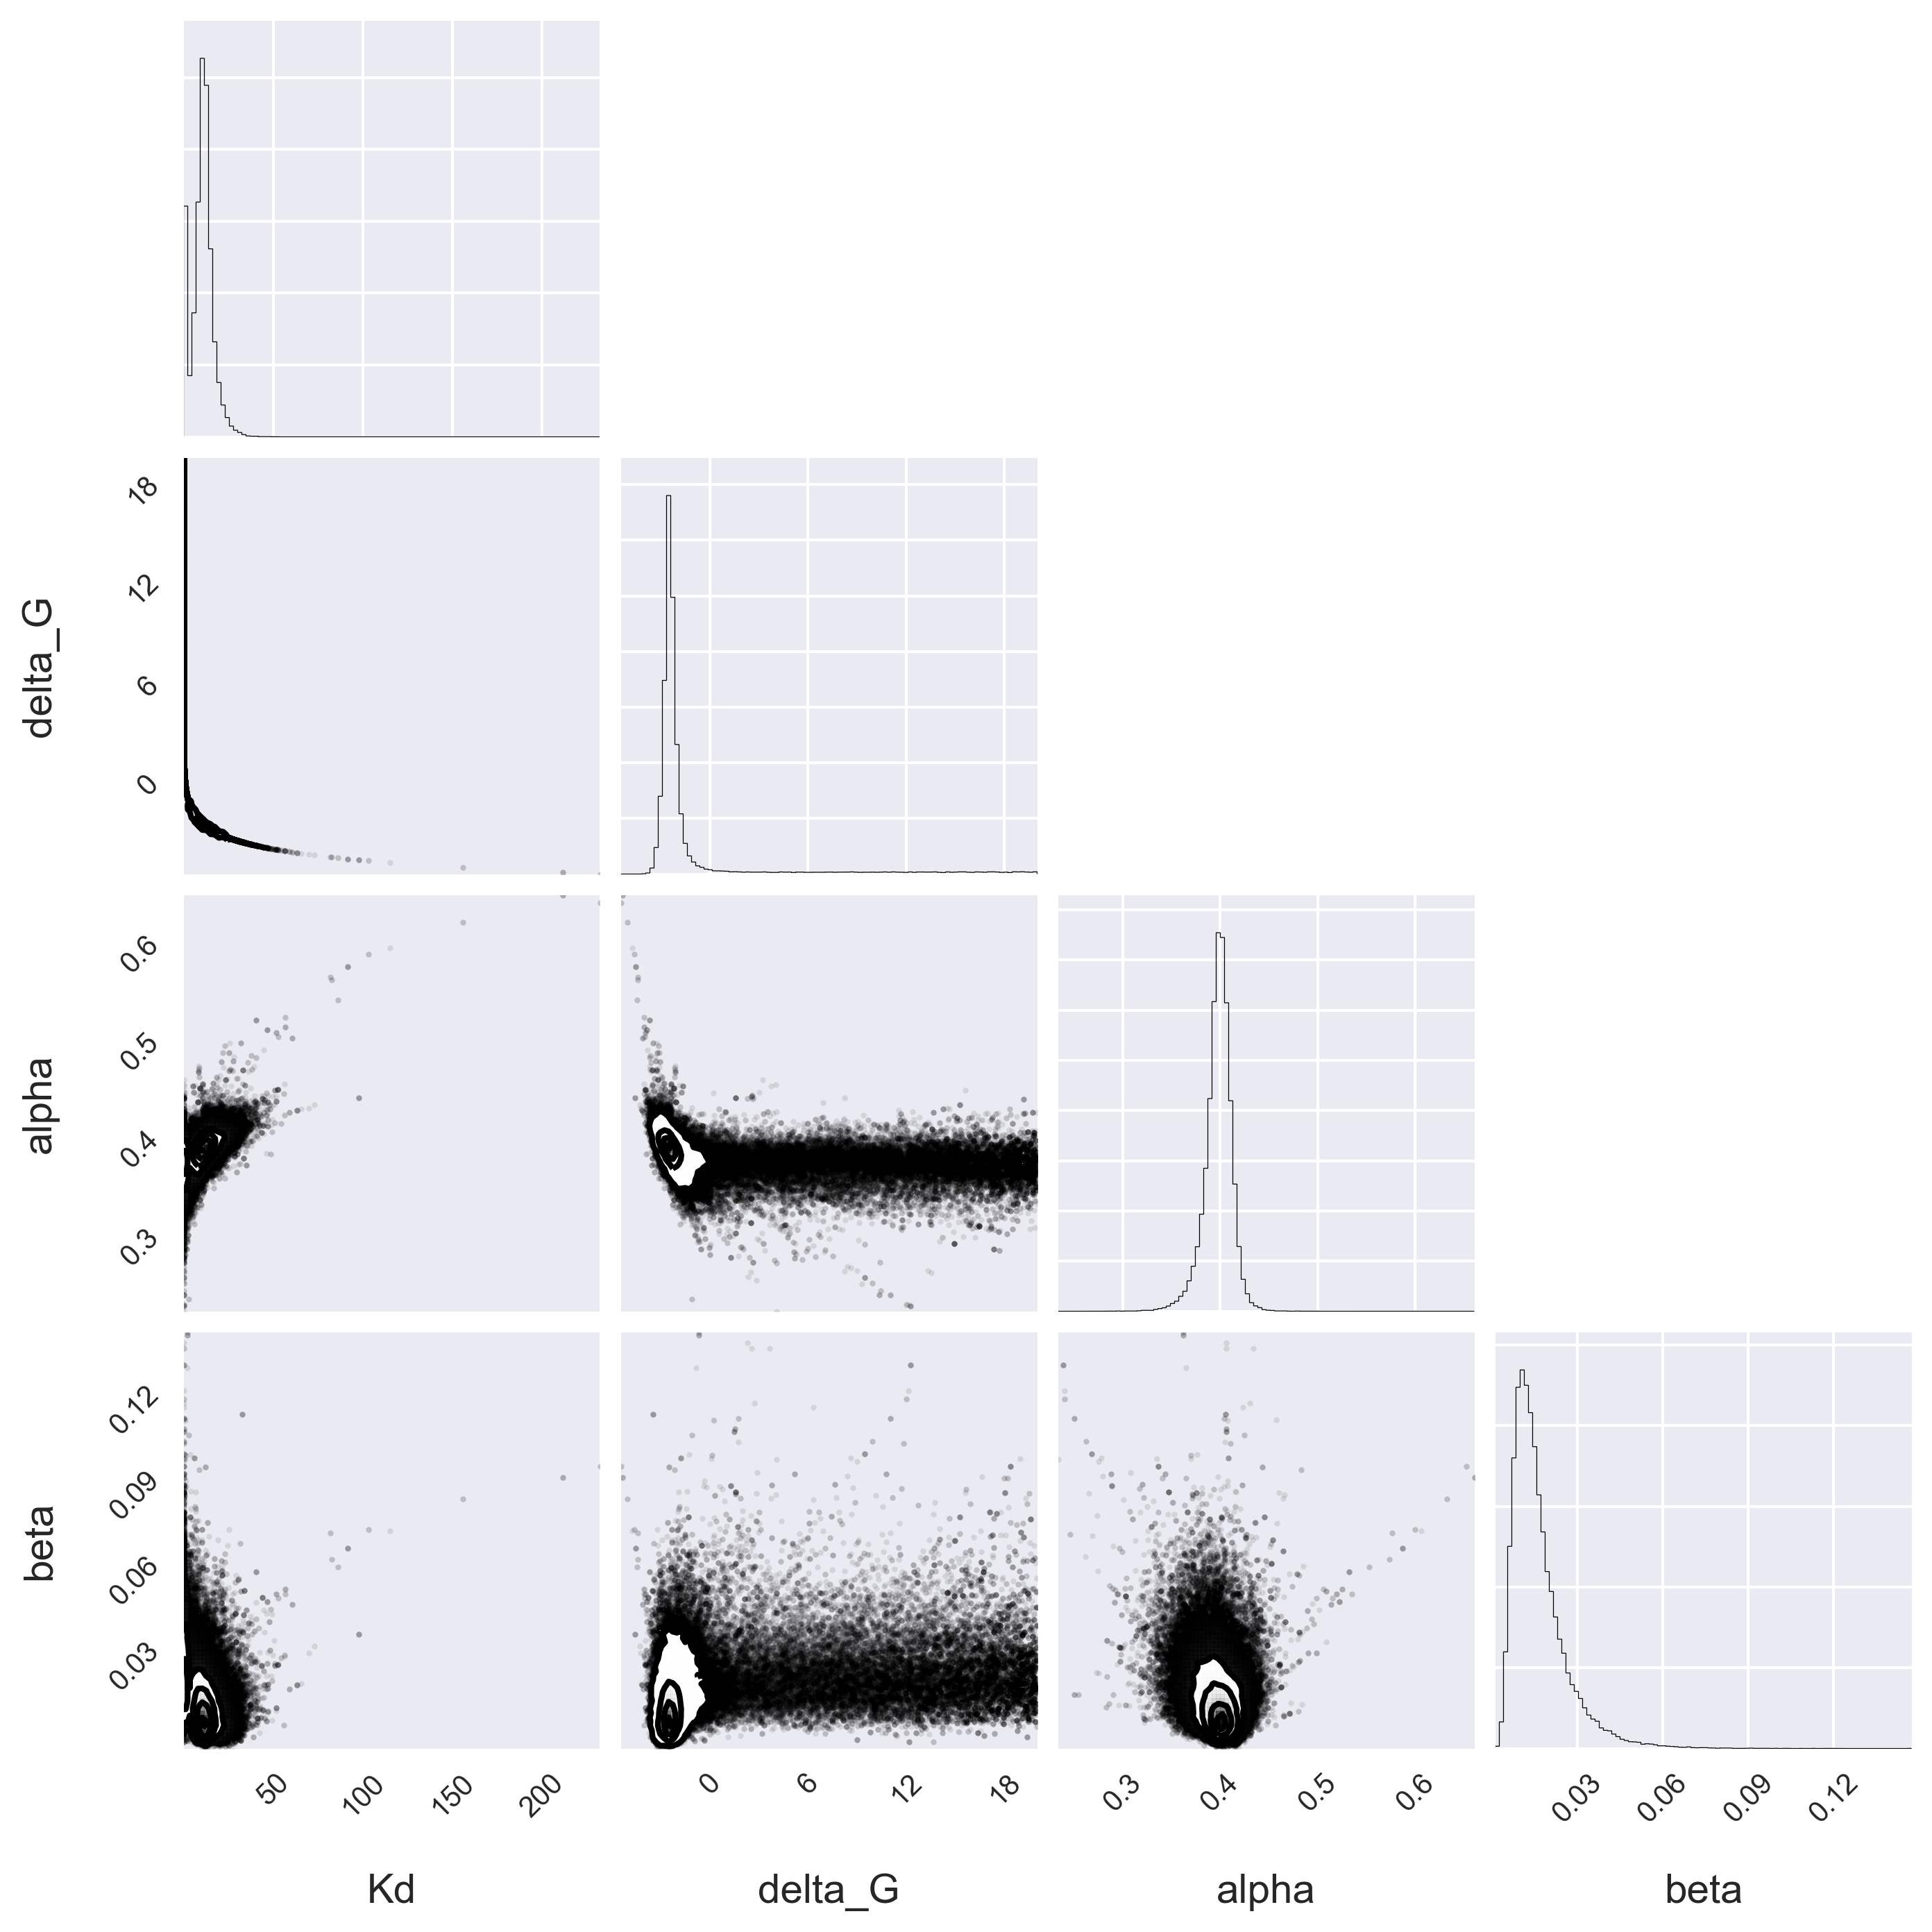

In [41]:
corner.corner(df_mcmc_cauchy[['Kd', 'delta_G', 'alpha', 'beta']], bins=100);

Strikingly, though the outlier still has some influence, the second (relevant) peak in the marginalized $K_d$ distribution is much better-resolved.  The tail on the marginalized $\Delta G$ distribution also falls off much more quickly. 

Now, let's see how this plays our in the credible regions.

In [42]:
# Compute HPD for Kd (must be using what was actually sampled)
map_ind = np.argmax(df_mcmc_cauchy['lnprob'])
delta_G_mode = df_mcmc_cauchy['delta_G'].iloc[map_ind]
delta_G_hpd = bebi103.hpd(df_mcmc_cauchy['delta_G'].values, 0.68)
Kd_mode = np.exp(-delta_G_mode)
Kd_hpd = np.exp(-delta_G_hpd)

# Compute HPD for alpha
alpha_mode = df_mcmc_cauchy['alpha'].iloc[map_ind]
alpha_hpd = bebi103.hpd(df_mcmc_cauchy['alpha'].values, 0.68)


print("""
ΔG = [{1:.2f}   {0:.2f}    {2:.2f}]  in weird units
Kd = [{4:.2e}   {3:.2e}    {5:.2e}]  nM
α = [{7:.3f}   {6:.3f}    {8:.3f}]
""".format(delta_G_mode, delta_G_hpd[0], delta_G_hpd[1],
           Kd_mode, Kd_hpd[1], Kd_hpd[0], 
           alpha_mode, alpha_hpd[0], alpha_hpd[1]))


ΔG = [-2.92   -2.49    -1.99]  in weird units
Kd = [7.31e+00   1.21e+01    1.86e+01]  nM
α = [0.389   0.402    0.412]



The credible region for $K_d$ is still broad, but less so than for the curve fit without outlier detection.  Importantly, we get a most probable $K_d$ that is a factor of two larger than before.  To compare the two, let's compute plot the best-fit curves on the same plot.

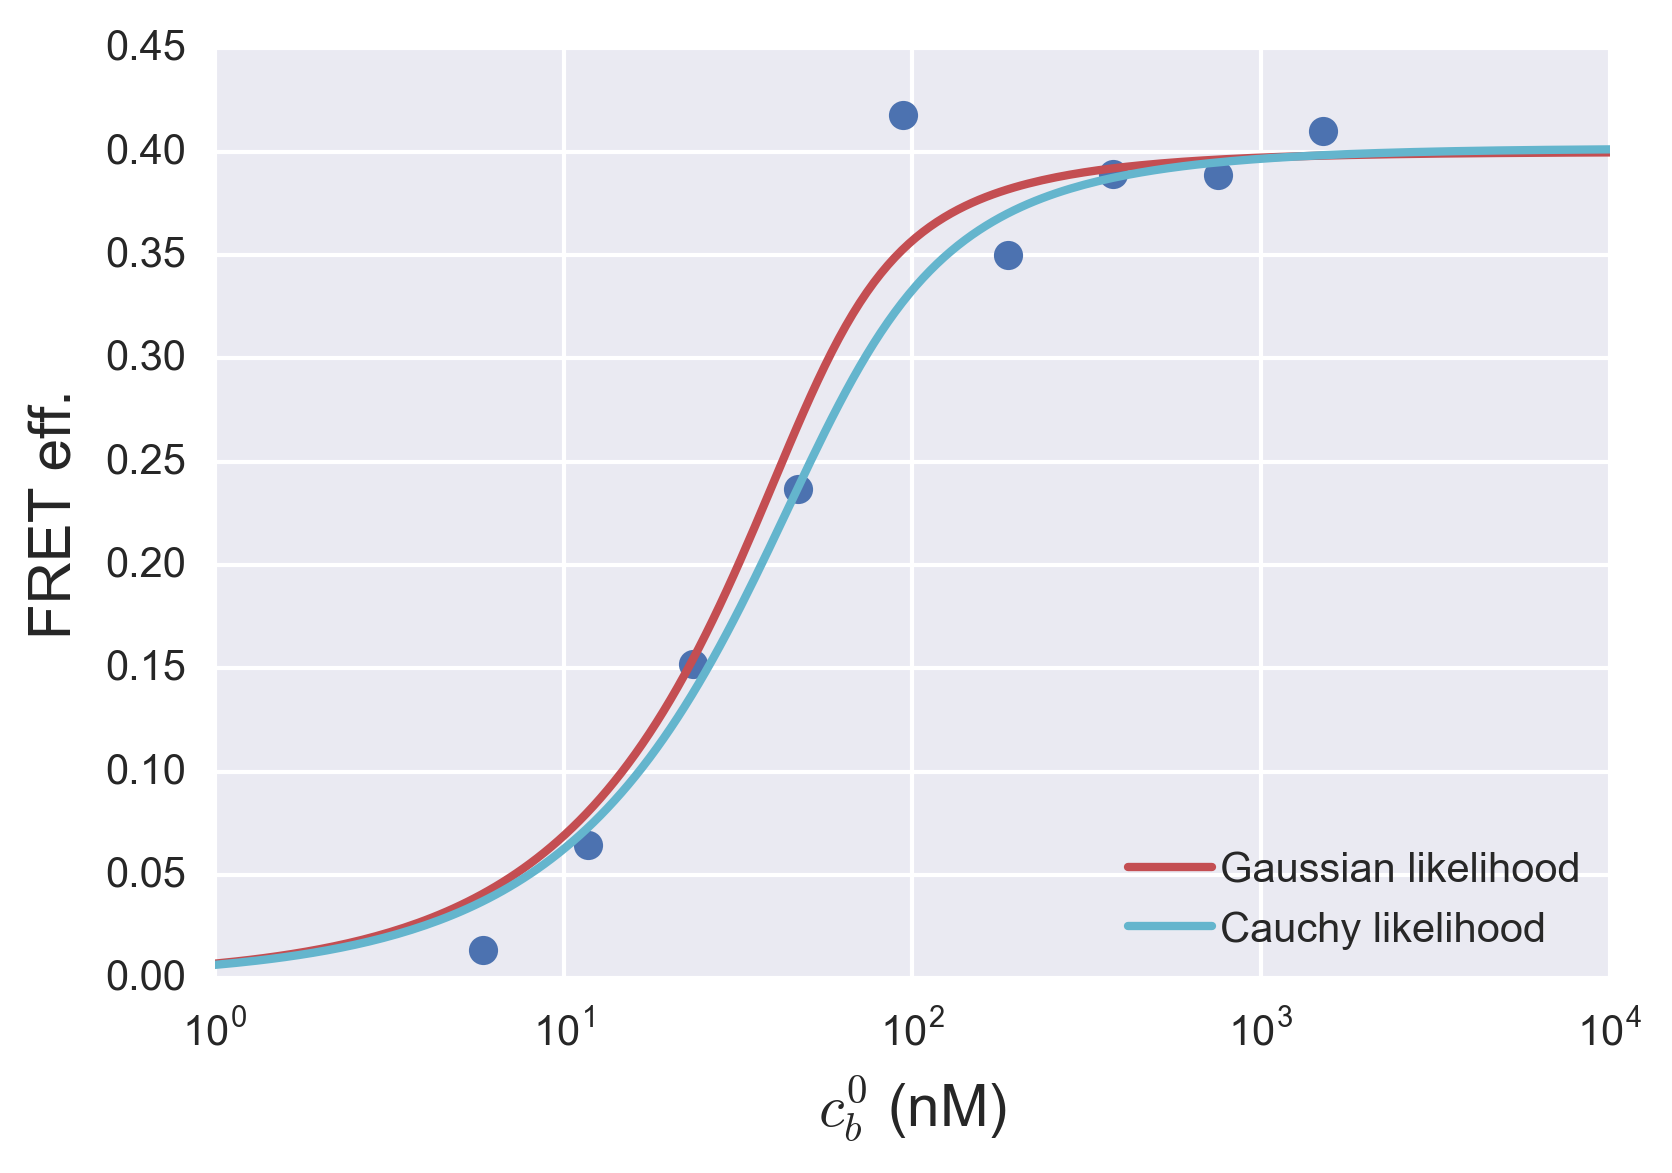

In [45]:
# Generate smooth curves
cb0_smooth = np.logspace(0, 4, 200)
map_ind = np.argmax(df_mcmc_gauss['lnprob'])
p = df_mcmc_gauss[['delta_G', 'alpha', 'sigma']].iloc[map_ind].values
e_smooth_g = fret_efficiency(p, ca0[0], cb0_smooth)

map_ind = np.argmax(df_mcmc_cauchy['lnprob'])
p = df_mcmc_cauchy[['delta_G', 'alpha', 'beta']].iloc[map_ind].values
e_smooth_c = fret_efficiency(p, ca0[0], cb0_smooth)


# Make the plot
plt.semilogx(cb0, e, 'o')
plt.semilogx(cb0_smooth, e_smooth_g, '-', color=sns.color_palette()[2],
             label='Gaussian likelihood')
plt.semilogx(cb0_smooth, e_smooth_c, '-', color=sns.color_palette()[5], 
             label='Cauchy likelihood')
plt.xlabel(r'$c_b^0$ (nM)')
plt.ylabel('FRET eff.')
plt.legend(loc='lower right');

We can see from the plot that the Cauchy likelihood results is far less influence from the outlier.  We can plot a set of curves generated from the Cauchy samples as we did for the Gaussian likelihood.  It is instructive to plot these side-by-side.

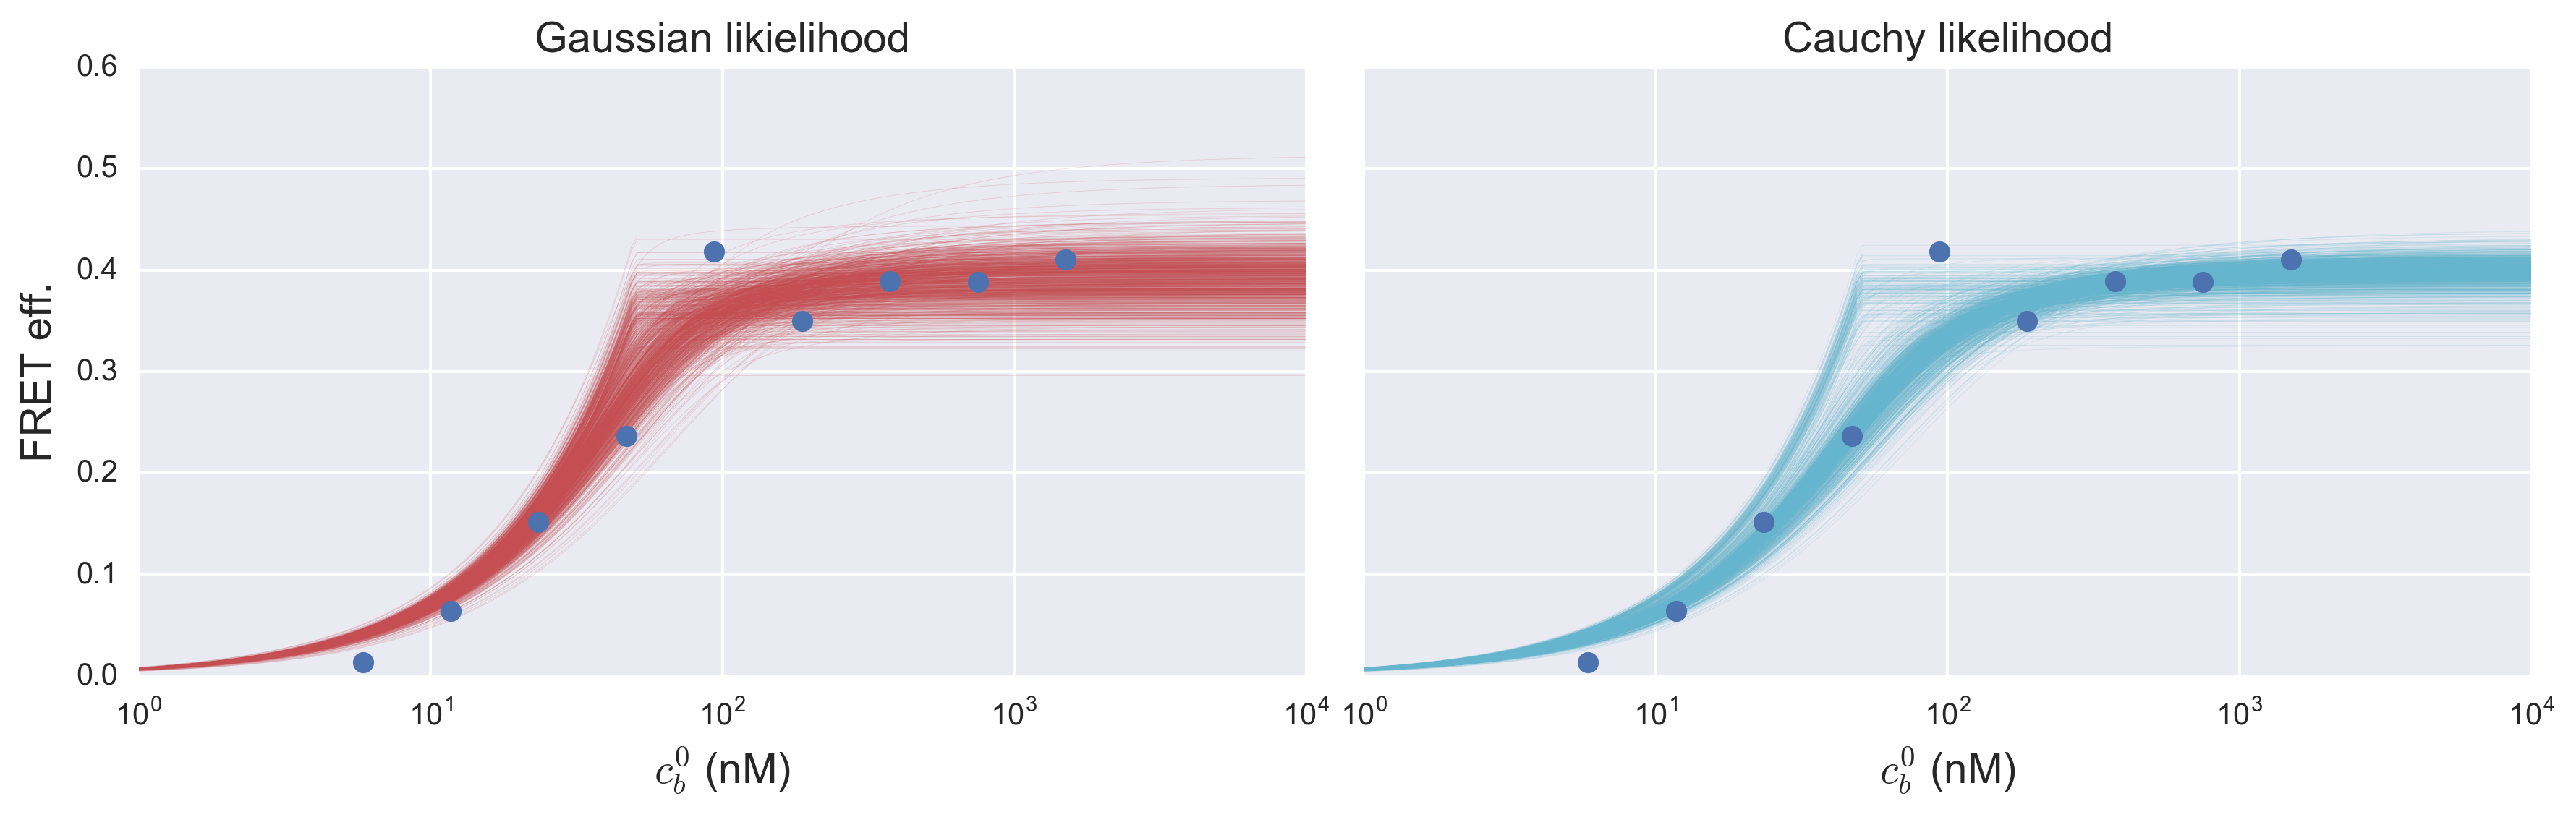

In [46]:
# Make a list of DataFrames and colors
dfs = [df_mcmc_gauss, df_mcmc_cauchy]
c = [sns.color_palette()[2], sns.color_palette()[5]]

# Set up figure
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))

for i, df_ in enumerate(dfs):
    # Which parameter samples to make smooth curves out of
    sample_inds = np.random.choice(np.arange(len(df_), dtype=int), 1000)

    # Smooth x-values
    cb0_smooth = np.logspace(0, 4, 200)
    # Make the plot
    ax[i].semilogx(cb0, e, 'o', zorder=2)

    for ind in sample_inds:
        p = df_[['delta_G', 'alpha', 'lnprob']].iloc[ind].values
        e_smooth = fret_efficiency(p, ca0[0], cb0_smooth)
        ax[i].semilogx(cb0_smooth, e_smooth, '-', color=c[i],
                       lw=0.2, alpha=0.2, zorder=1)

    ax[i].set_xlabel(r'$c_b^0$ (nM)')

ax[0].set_title('Gaussian likielihood')
ax[1].set_title('Cauchy likelihood')
ax[0].set_ylabel('FRET eff.')
plt.tight_layout(w_pad=0.2);

We see that we get some fraction of the curves jump toward the outlier, mostly ignoring the other points at the rightward side of the curve.  We don't see curves that try to walk between the outlier and the remaining data.

So, if we were to report a $K_d$ in a paper, we would be very clear about our parameter estimation method, including explicit mention of the Cauchy likelihood, and report $K_d = 12.0^{+6.5}_{-5.0}$ nM.

Note that this is a nice way to present a confidence interval on $K_d$ because dissociation constants, being exponentiations of free energies, can often have asymmetric distributions.

<br />
<br />

### Problem 5.2: solution

We can borrow some of the code from [Homework 3](hw3_solutions.html) to define our posterior.  Unlike in that problem, we will not marginalize over the unknown variance in the measurements, $\sigma$, but keep it out of interest.  In this case, the posterior is

\begin{align}
P(V_0, c, \delta, \sigma \mid \{t_i, V_i\}, I) \propto \frac{1}{\sigma^{n+1}}
\prod_i \exp\left[-\frac{1}{2\sigma^2}\sum_i\left(V_i - V(t;V_0,c,\delta)\right)^2\right].
\end{align}

We will also explicitly bound our parameter values to be $0 \le c,\delta \le 10$ inside the log posterior function.

In [6]:
@numba.jit(nopython=True)
def viral_load_model(p, t):
    """Perelman model for viral load"""
    # Unpack parameters
    V_0, c, delta, _ = p
            
    # If c and d are close, use limiting expression
    if abs(c - delta) < 1e-9:
        return V_0 * (1 + delta * t +  (delta * t)**2 / 2) * np.exp(-delta * t)

    # Proceed with typical calculation
    bracket_term = c / (c - delta) * (np.exp(-delta * t) - np.exp(-c * t)) \
                                        - delta * t * np.exp(-c * t)

    return V_0 * (np.exp(-c * t) + c / (c - delta) * bracket_term)


@numba.jit(nopython=True)
def resid(p, t, V):
    """Residuals for viral load model with log parameters."""
    return V - viral_load_model(p, t)


@numba.jit(nopython=True)
def log_posterior(p, t, V, c_max, delta_max):
    """Log posterior for viral load model."""

    # Unpack parameters
    V_0, c, delta, sigma = p
    
    # Enforce bounds
    if np.any(p < 0) or (c > c_max) or (delta > delta_max):
        return -np.inf

    return -(len(t) + 1) * np.log(sigma) \
                - np.sum(resid(p, t, V)**2) / 2 / sigma**2

Of course now we have to load in the data.

In [7]:
# Load data set using Pandas
df = pd.read_csv('../data/hiv_data.csv', comment='#')

We now just have to specify our initial walker positions and our other MCMC parameters and we can take our samples.  We will sample $c$, $\delta$, and $V_0$ out of uniform distributions and $\sigma$ out of an exponential. 

In [8]:
# Arguments to pass to log posterior (need NumPy arrays because using Numba)
args = (df['Days after administration'].values, 
        df['RNA copies per mL'].values, 10, 10)

# Parameters and how we start them
p_dict = collections.OrderedDict([('V_0', (np.random.uniform, (1e5, 2e5))),
                                  ('c', (np.random.uniform, (0, 10))),
                                  ('delta', (np.random.uniform, (0, 10))),
                                  ('sigma', (np.random.exponential, (1e3,)))])

# Define walker settings
n_walkers = 50
n_burn = 50000
n_steps = 50000

# Run MCMC
df_mcmc = bebi103.run_ensemble_emcee(log_posterior, n_burn, n_steps, 
                                     n_walkers=n_walkers, p_dict=p_dict, 
                                     args=args)

Now that we have our samples, we can plot the results as a corner plot.

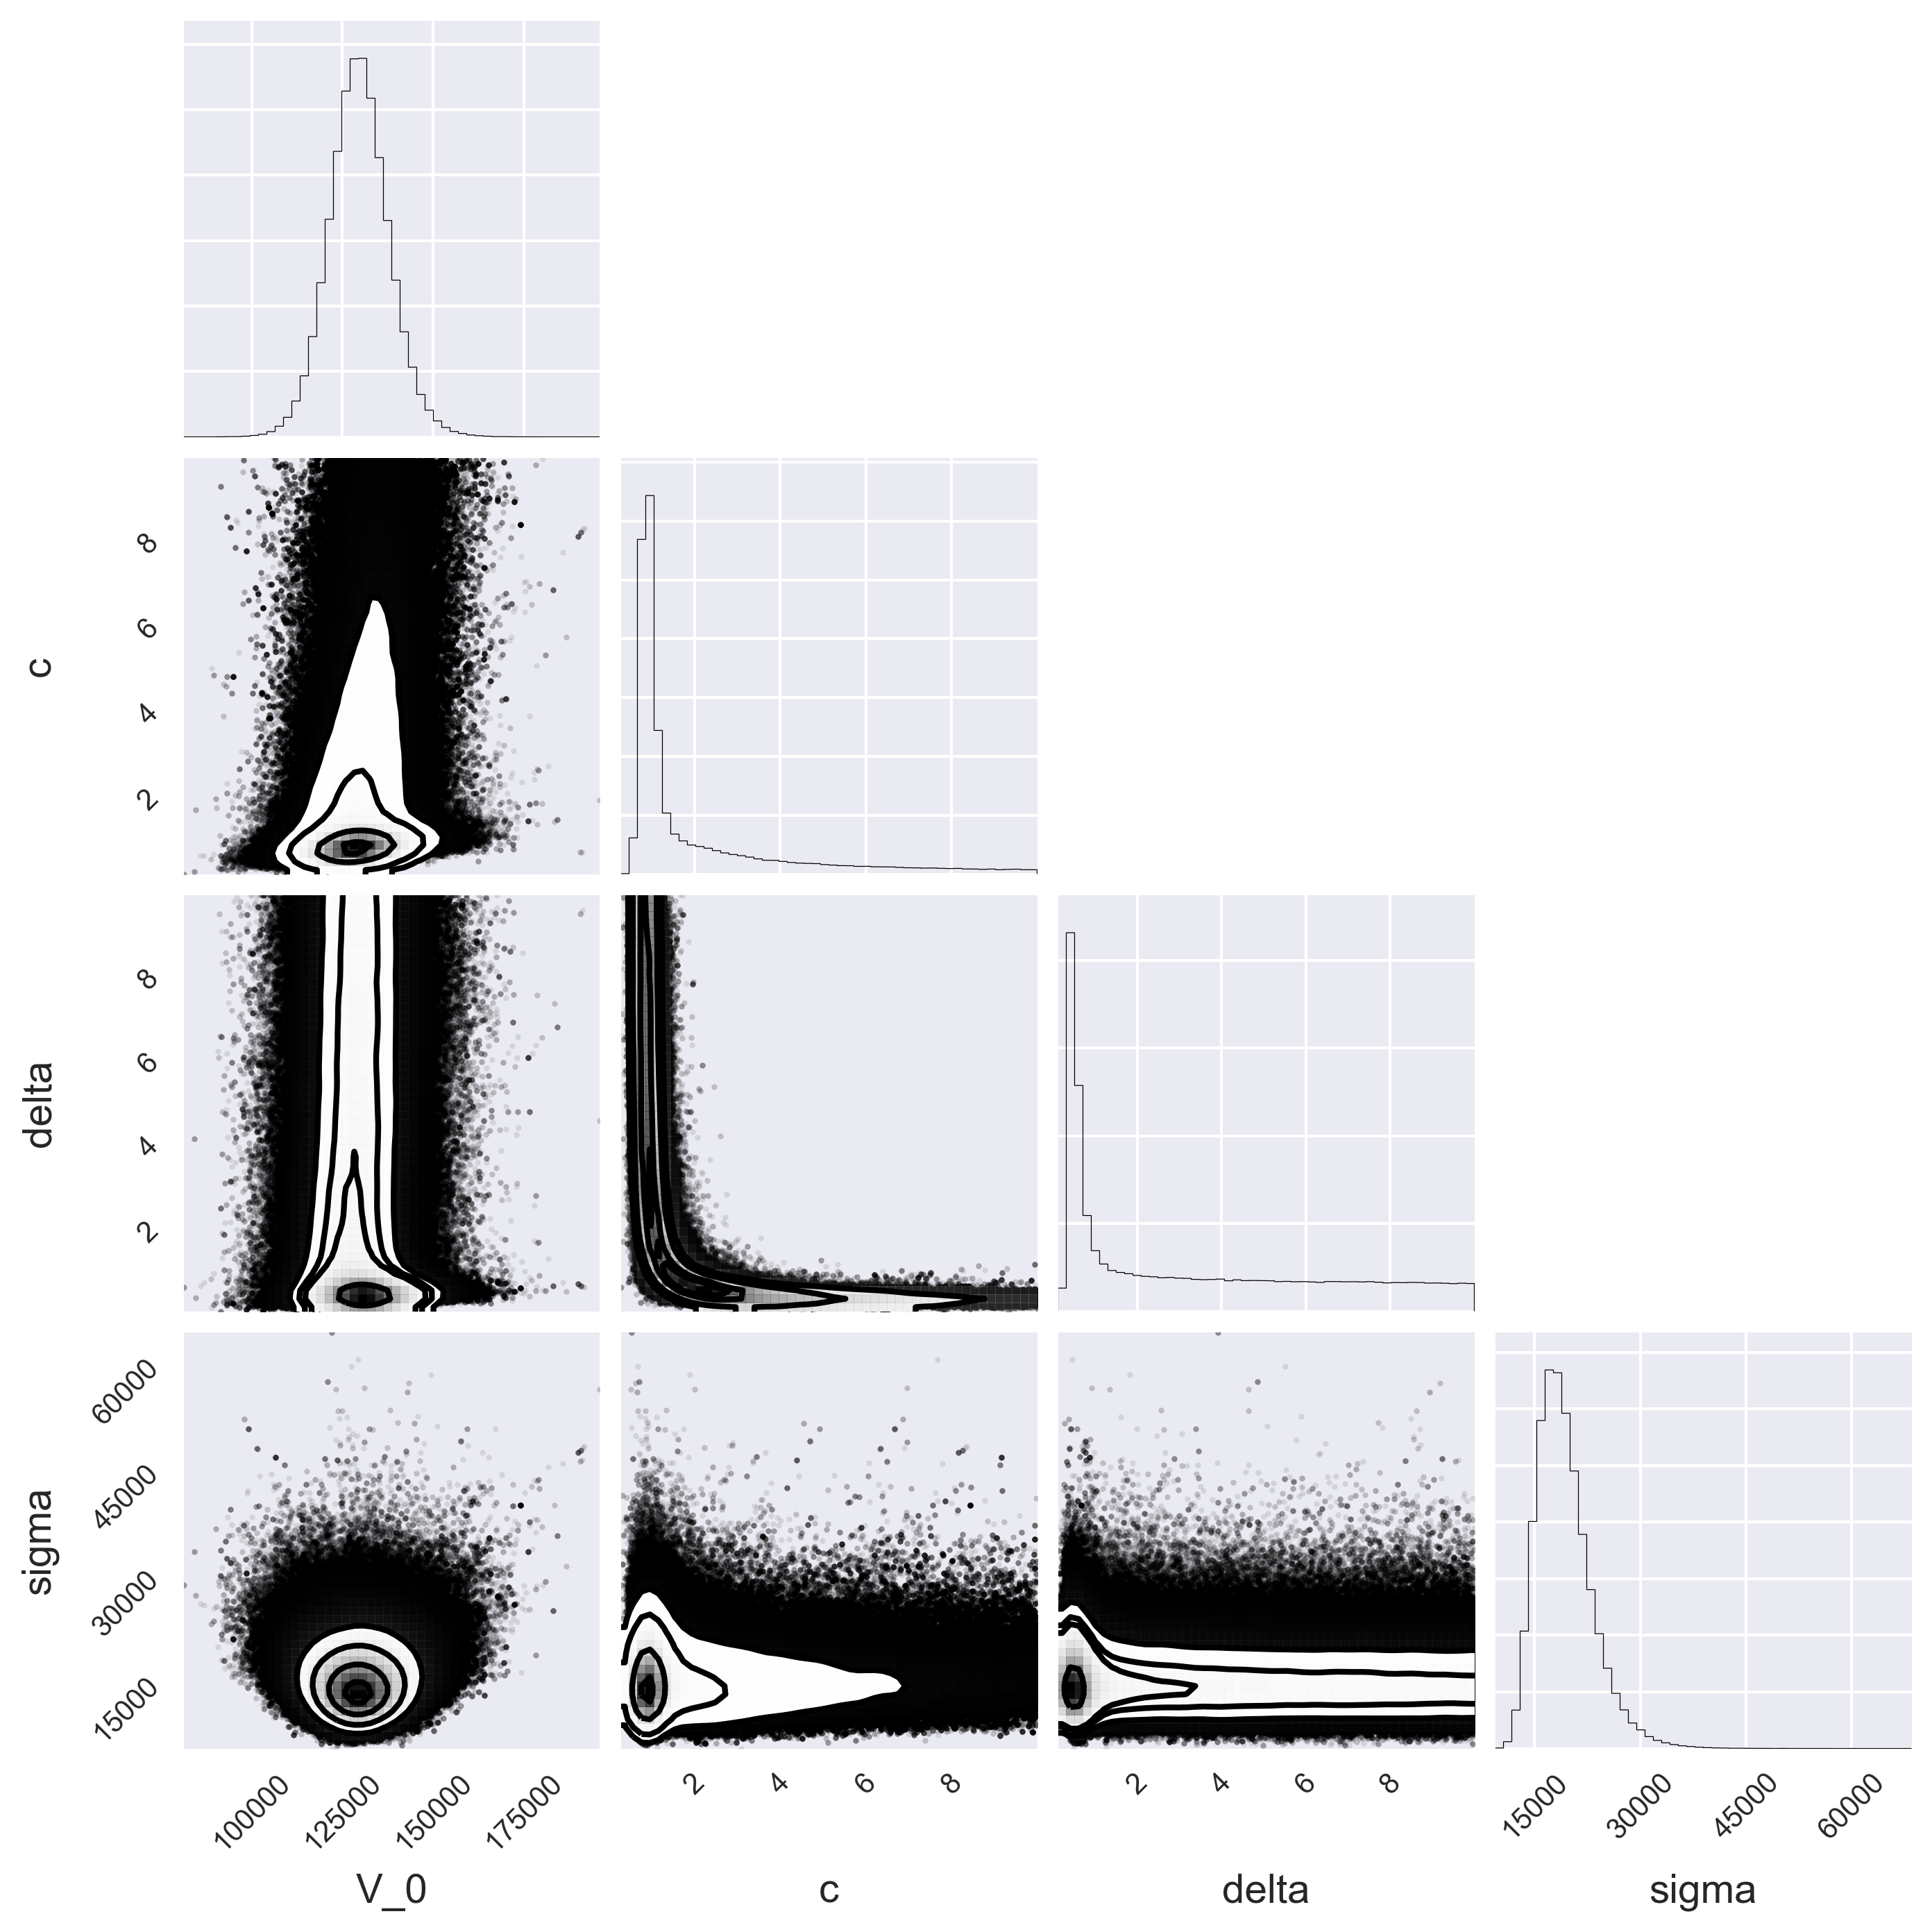

In [9]:
corner.corner(df_mcmc[df_mcmc.columns[:-2]], labels=df_mcmc.columns[:-2],
              bins=50, smooth=1);

The marginalized distributions for $c$ and $\delta$ have very long tails.  Note that the MAP we found in homework 3 approximately gives the peak of the marginal distribution for $\delta$, but *not* for $c$!  The MCMC MAP is about what we got in HW3.

In [10]:
# Find and display MCMC MAP
map_ind = np.argmax(df_mcmc['lnprob'])
df_mcmc.ix[map_ind]

V_0       129409.798723
c              2.714815
delta          0.517867
sigma      16040.080401
lnprob      -173.303951
chain          7.000000
Name: 393270, dtype: float64

It is more stark when we plot the marginalized distribution of $c$ along with the MAP.

In [ ]:
# Pull out MAP
c_map = df_mcmc['c'].ix[map_ind]

# Plot histogram and map as vertical red line
_ = plt.hist(df_mcmc['c'], bins=800, normed=True, histtype='step', lw=2)
plt.plot([c_map, c_map], plt.gca().get_ylim(), '-', color=sns.color_palette()[2])

# Clean up
plt.xlabel('$c$ (1/days)')
plt.ylabel(r'$P(c\mid D, I)$ (days)')

Without any other information, this suggests that using the MAP would overestimate the most probable HIV clearance rate due to the drug by about a factor of 5!  Then again, the reason we have the large peak at $c\approx 0.5$ days$^{-1}$ is that $\delta$ is allowed to take many values for that value of $c$, thereby allowing for a much better swatch of parameter space.

Now, we'll make a prettier plot using Seaborn and KDE on the marginalized posteriors.

/Users/Justin/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


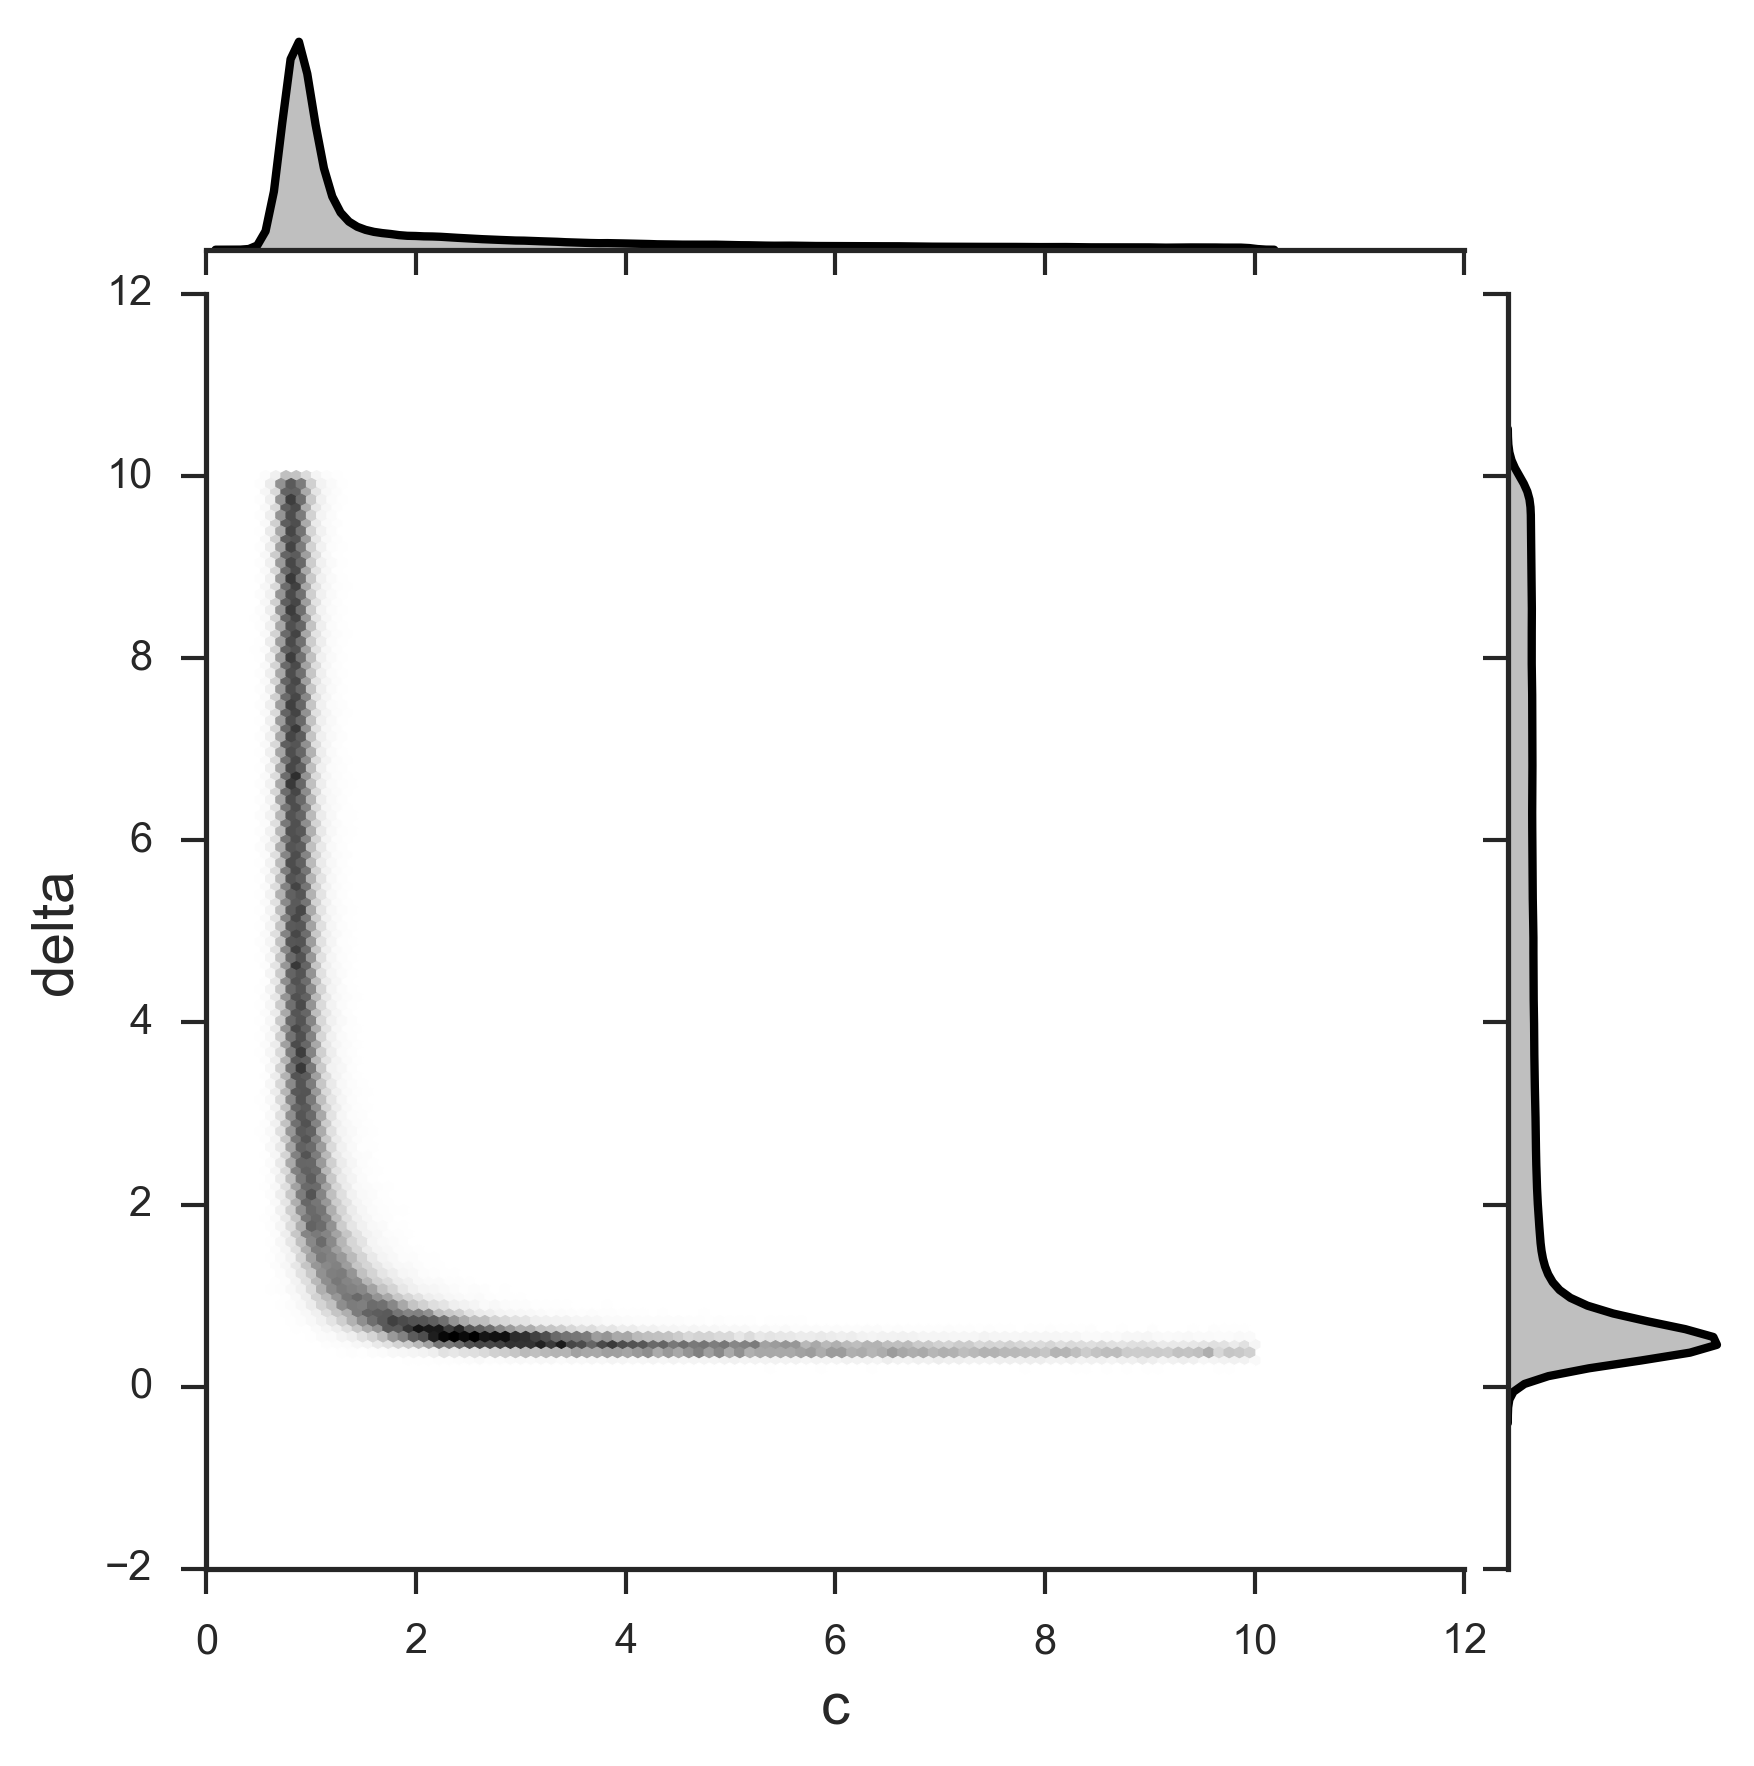

In [11]:
# Make plot of joint distribution
with sns.axes_style('ticks'):
    g = sns.JointGrid(x='c', y='delta', data=df_mcmc)
    g = g.plot_joint(plt.hexbin)
    g = g.plot_marginals(sns.kdeplot, shade=True, color='k')

Finally, we will make a clearer contour plot of the marginalized posterior using the utility function I wrote, `bebi103.norm_cumsum_2d()`.

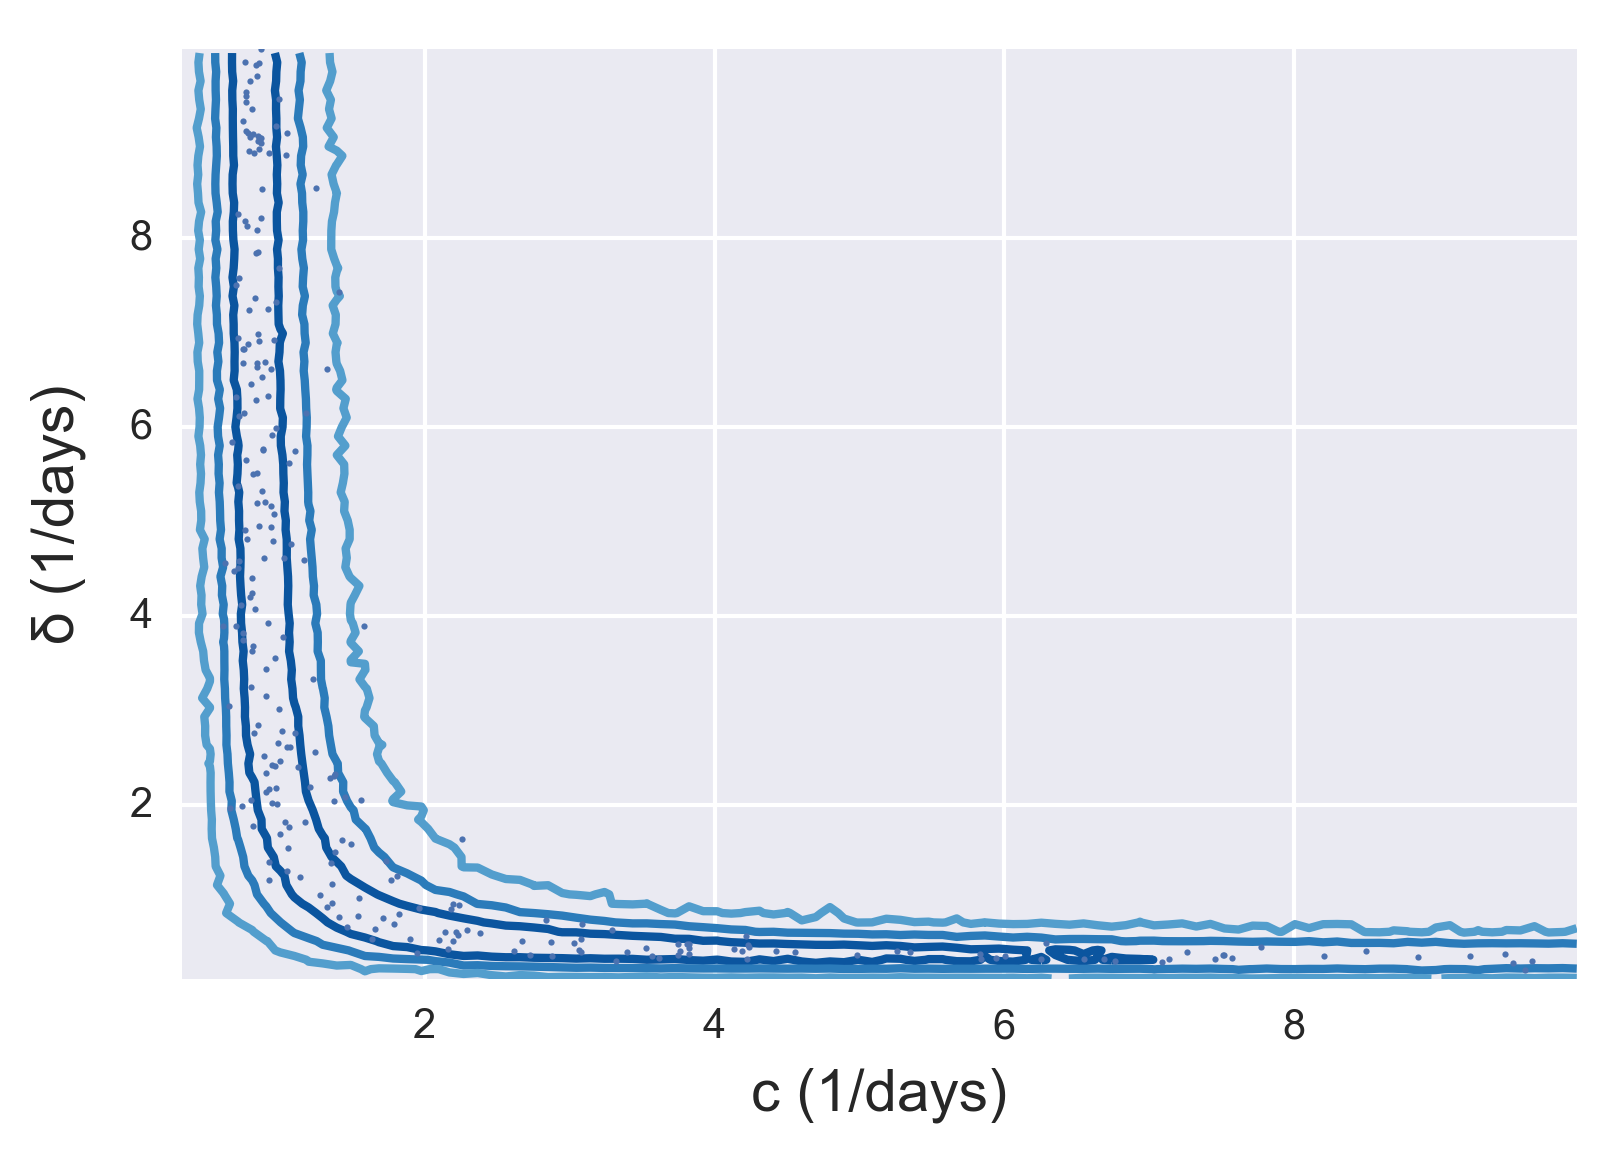

In [12]:
# Make normalized cumulative sum array
norm_cum_sum, c, delta = bebi103.norm_cumsum_2d(df_mcmc['c'], df_mcmc['delta'])

# Plot the contour plot
colors = sns.color_palette('Blues_r')[:3]
plt.contour(c, delta, norm_cum_sum, levels=(0.6827, 0.9545, 0.9973), 
            colors=colors)

# Plot 1/10000th of the samples
plt.plot(df_mcmc['c'].values[::10000], df_mcmc['delta'].values[::10000], '.',
         markersize=3)

# Axis labels
plt.xlabel('c (1/days)')
plt.ylabel('δ (1/days)');

<br />
<br />

### Problem 5.3: solution

We will start with the extra credit first, showing how we do automatic gating. Before beginning the gating procedure, we will load in a test data set and extract the forward scattering area, side scattering area, and fluorescence from the DataFrame. We will only consider 

In [12]:
# Get scattering data
df = pd.read_csv('../data/flow_data/20160807_0_RBS1027_10.0.csv')
inds = (df['FSC-A'] > 0) & (df['SSC-A'] > 0) & (df['FITC-A'] > 0)
fsc, ssc, yfp = df.loc[inds,['FSC-A', 'SSC-A', 'FITC-A']].values.transpose()

#### Gating with the histogram method

For the first method, we do the following.
1. Compute a 2D histogram of the forward/side scattering data.
2. Optionally smooth the 2D histogram with a Gaussian filter.
3. Draw a contour corresponding to a given percentile. E.g., if we want only the data points that with the most often encountered forward/side scattering pairs, we would choose a high percentile, like 90.
4. Retain all points within this contour.

To get a feel for how it works, let's first plot our data with some contours. We will plot the contours that contain the top 10, 20, 50, and 80 percent of the data.

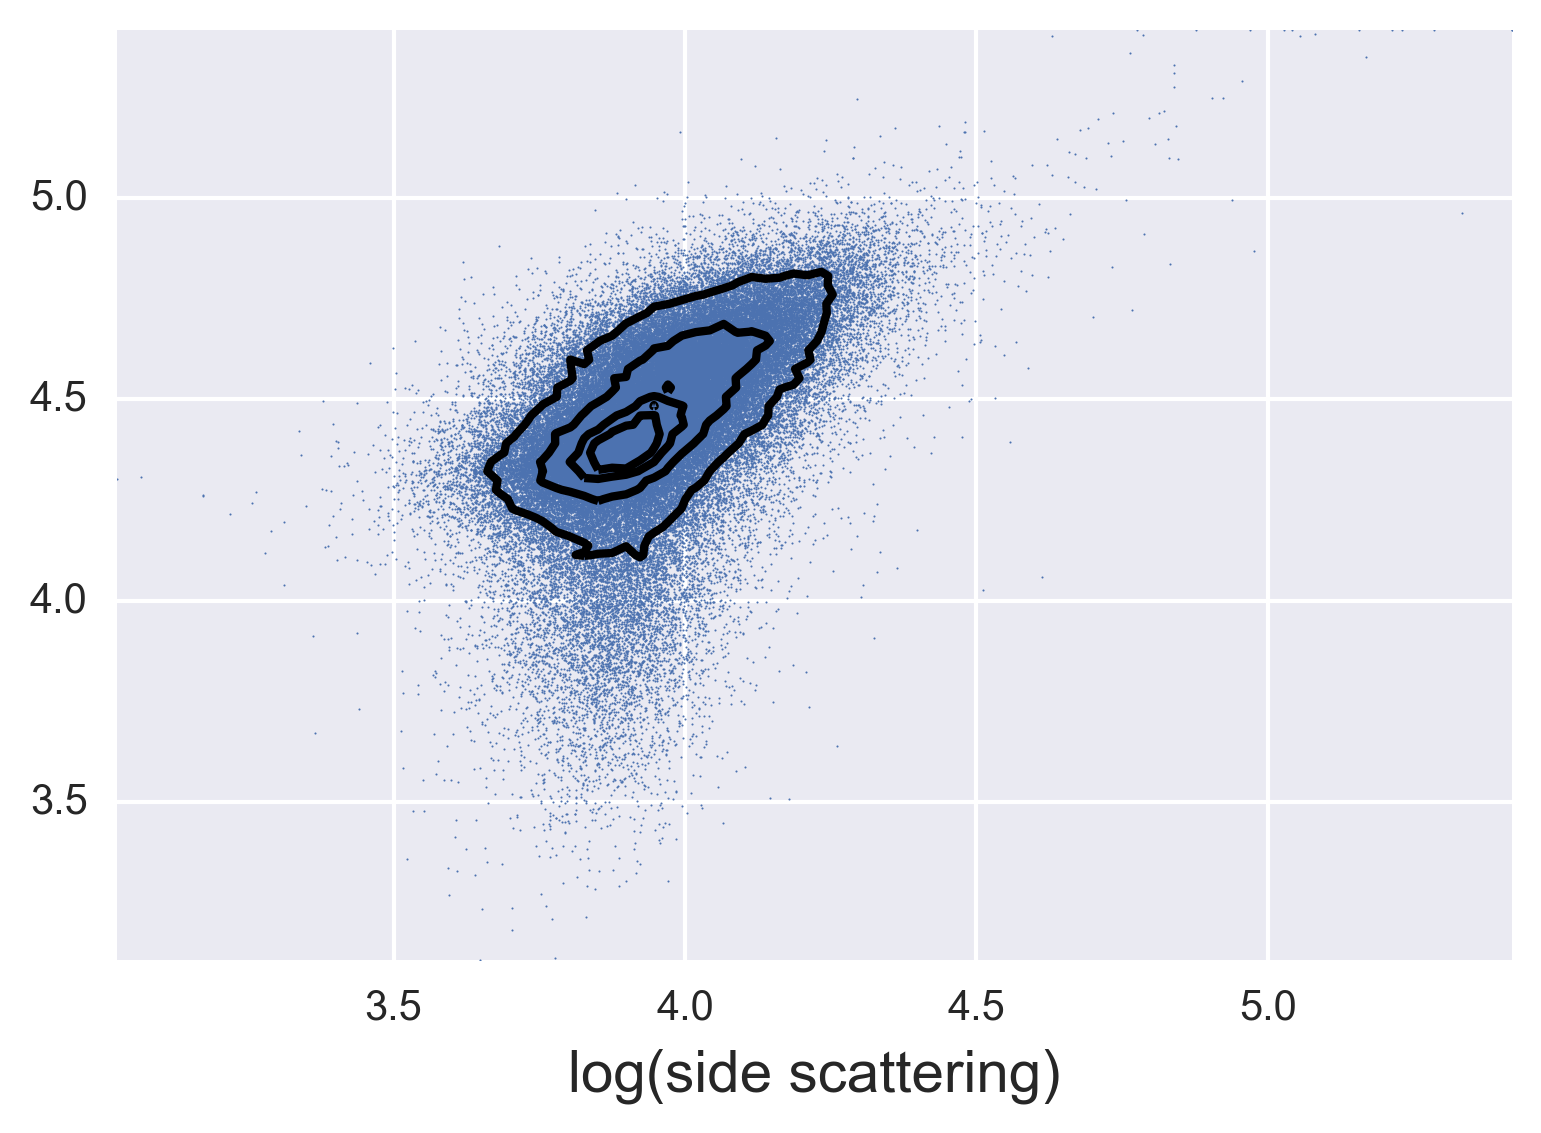

In [3]:
# Generate x, y, z data for histogram
z, x, y = bebi103.norm_cumsum_2d(np.log10(fsc), np.log10(ssc), bins=100)

# Plot the data
plt.plot(np.log10(fsc), np.log10(ssc), '.', markersize=1, rasterized=True)

# Plot contours for 50th, 80th, and 90th percentiles
plt.contour(x, y, z, levels=[0.1, 0.2, 0.5, 0.8], colors='black', zorder=3)

# Label axes
plt.xlabel('log(forward scattering)')
plt.xlabel('log(side scattering)');

We might want to choose all of the points in the innermost contour, which would correspond to the 90th percentile and above.

To code this up, we first need to pay attention to the fact that sometimes the contours are disconnected. For example, in the above plot, we can see that for some levels, there are a couple small contours disconnected from the large one. We want to only consider the largest contour, so we'll write a function to compute the area of a contour.

In [4]:
def shoelace_area(x, y):
    """
    Compute the area of a regular polygon using the shoelace formula.
    
    Parameters
    ----------
    x : ndarray
        x-coordinates of vertices of regular polygon
    y : ndarray
        y-coordinates of verticies of regular polygon
        
    Returns
    -------
    output : float
        Area of regular polygon.
    
    Notes
    -----
    .. See https://en.wikipedia.org/wiki/Shoelace_formula.

    .. If the polygon is irregular (has crossing lines), the result
       will be bogus, and no warning will be given.
    """
    return np.abs(np.dot(x, np.roll(y, 1)) - np.dot(np.roll(x, 1), y)) / 2    

Now that we have that, we can code up our gating. The function will return an array of Booleans that say whether or not we should include a given data point. In this function, we use the `matplotlib._cntr` submodule, which is deep the guts of Matplotlib, which is what generates the contours under the hood.

In [5]:
def gate_histogram(fsc, ssc, bins=100, uselog=True, percentile=80, 
                   smooth_sigma=None):
    """
    Gate flow data using the 2D histogram method.
    
    Parameters
    ----------
    fsc : ndarray
        Forward scattering data
    ssc : ndarray
        Side scattering data
    bins : int, default 100
        Number of bins along each access to use in histogram
    uselog : bool, default True
        If True, use the logarithm of scattering data to generate
        histogram.
    percentile : float, default 80
        Include data points within a contour that encompasses the
        highest percentile of the data. E.g., if percentile = 90,
        data points within the contour containing the top 10% densest
        regions are used.
    smooth_sigma : float, default None
        If not None, then Gaussian smoothing is applied to the 
        2D histogram prior to drawing the contour. The smoothing kernel
        has sigma equal to smooth_sigma * extent of data. Recommended value
        is smooth_sigme = 0.01.
        
    Returns
    -------
    inds : ndarray of bools
        inds[i] is True if cell i is to be included and False otherwise.
        
    Notes
    -----
    .. It is not always possible to draw a contour. This most often
       happens when uselog=False and Gaussian smoothing is applied.
    """
    
    # Generate a 2D normalized histogram of data
    if uselog:
        z, x, y = bebi103.norm_cumsum_2d(np.log(fsc), np.log(ssc), bins=bins)
    else:
        z, x, y = bebi103.norm_cumsum_2d(fsc, ssc, bins=bins)

    # Smooth the histogram
    if smooth_sigma is not None:
        sigma = smooth_sigma * bins
        z = skimage.filters.gaussian(z, sigma)
        
    # Get the contour
    xx, yy = np.meshgrid(x, y)
    contour = matplotlib._cntr.Cntr(xx, yy, z)
    c = contour.trace((100-percentile) / 100)
    
    # Check to make sure we could generate a contour
    if len(c) == 0:
        raise RuntimeError('Unable to draw contour. Check input settings.')
    
    # Extract only polygons (last half of list is matplotlib details)
    c = c[:len(c)//2]
 
    # Use the contour that has the most area
    ind = np.argmax(np.array([shoelace_area(*pgon.T) for pgon in c]))

    # Make a matplotlib Path object so we can see if points are inside
    polygon = matplotlib.path.Path(c[ind][:-1])
    
    # Get points within polygon
    if uselog:
        return polygon.contains_points(np.vstack((np.log(fsc), np.log(ssc))).T)
    else:
        return polygon.contains_points(np.vstack((fsc, ssc)).T)

Now let's try gating this sample and plot the results.

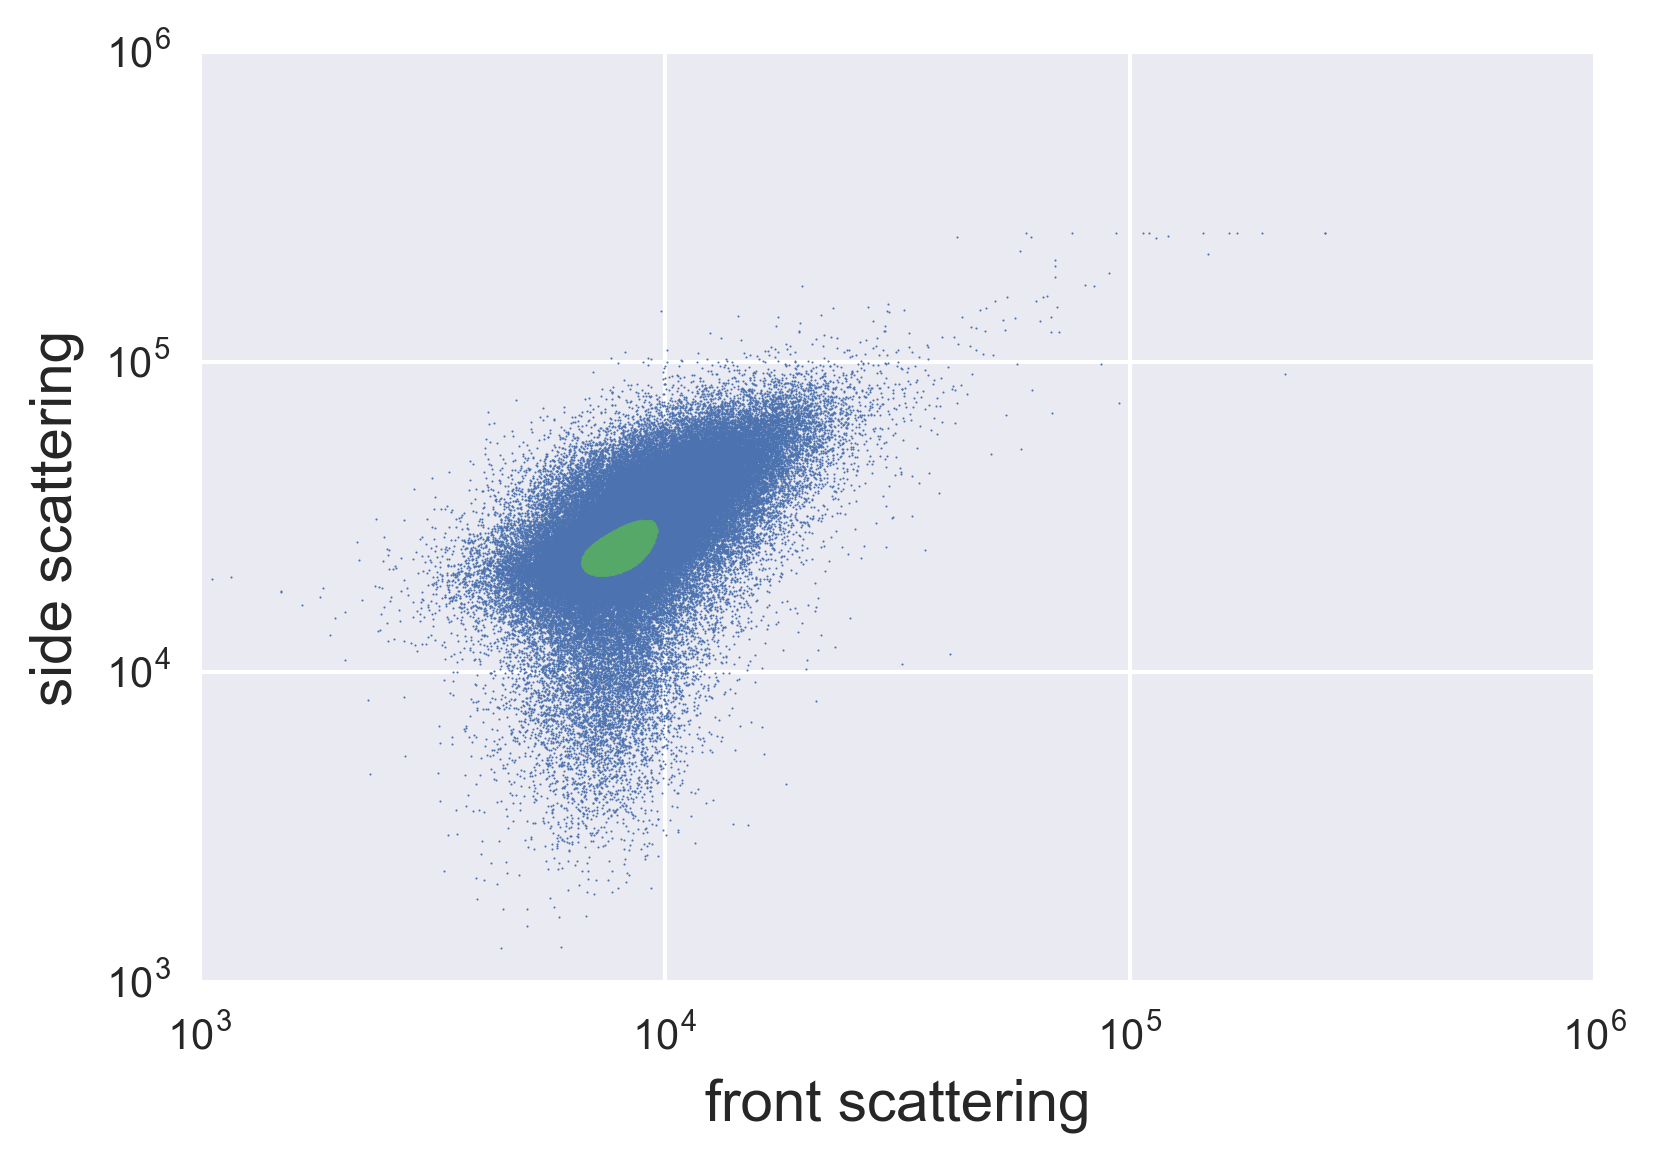

In [6]:
# Perform the gating
inds = gate_histogram(fsc, ssc, percentile=80, smooth_sigma=0.01)

# Plot the excluded and included data
plt.loglog(fsc[~inds], ssc[~inds], '.', markersize=1, rasterized=True)
plt.loglog(fsc[inds], ssc[inds], '.', markersize=1, rasterized=True)
plt.xlabel('forward scattering')
plt.ylabel('side scattering');

So, we got a nice subset of the data. Let's plot an ECDF of the fluorescence intensity values.

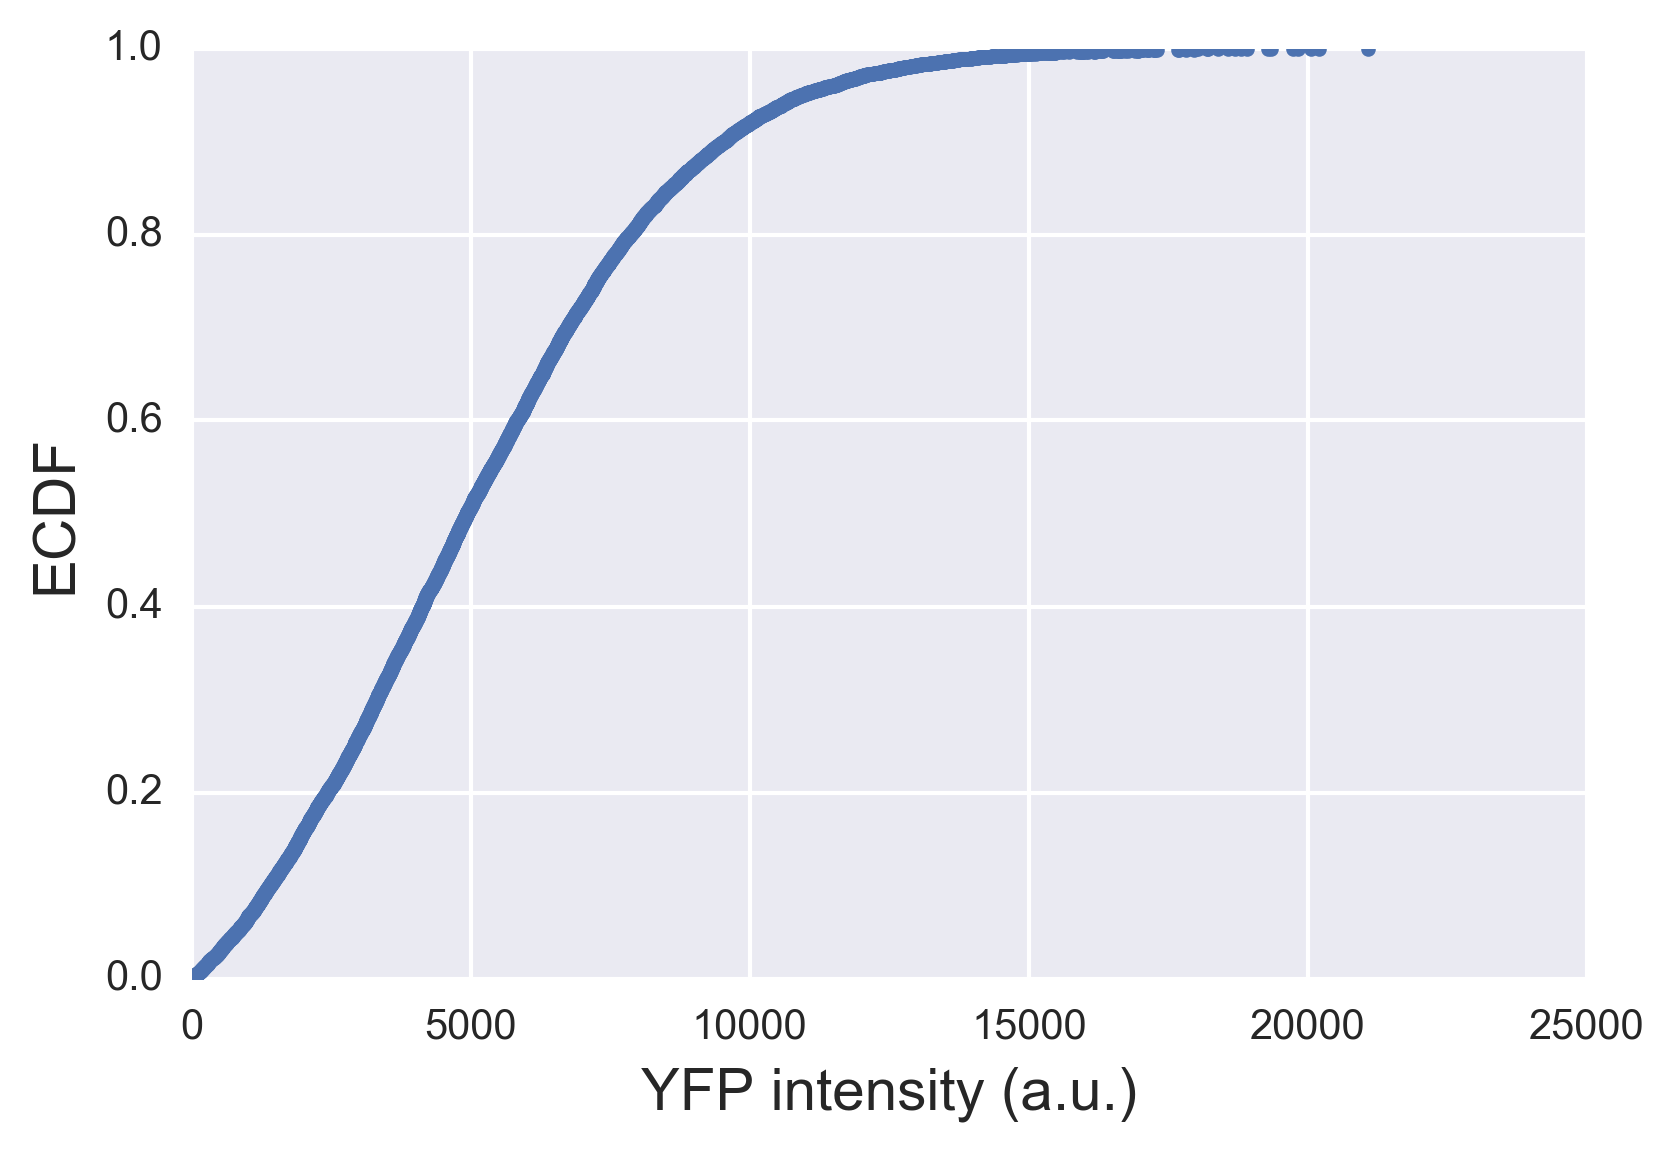

In [7]:
x, y = bebi103.ecdf(yfp[inds])
plt.plot(x, y, '.')
plt.xlabel('YFP intensity (a.u.)')
plt.ylabel('ECDF');

We can also compute the mean and its error bar.

In [8]:
np.mean(yfp[inds]), np.std(yfp[inds]) / np.sum(inds)

(5293.5117951426091, 0.21936990026703657)

Because we have so many samples, the error of the mean is tiny. For all practical purposes, it is negligible, and we will not consider it going forward.

Now that we have a means of doing the gating, we will perform gating for all files and add a column, `'gated'` with ones and zeros for which entries should be used. These are the files you downloaded.

In [9]:
# Get list of all file names
fnames = glob.glob('../data/flow_data/*.csv')

for f in fnames:
    # Load DataFrame
    df = pd.read_csv(f)

    # Extract useful indices
    inds = (df['FSC-A'] > 0) & (df['SSC-A'] > 0) & (df['FITC-A'] > 0)

    # Store a NumPy arrays for speed
    fsc, ssc, yfp = df.loc[inds,['FSC-A', 'SSC-A', 'FITC-A']].values.transpose()

    # Gate them
    gate_inds = gate_histogram(fsc, ssc, percentile=80, smooth_sigma=0.01)

    # Add gating information
    df.loc[inds, 'gate'] = gate_inds.astype(int)

    # Negative readings fail gating
    df.loc[~inds, 'gate'] = 0
    
    # Make sure the gate column is integer
    df['gate'] = df['gate'].astype(int)

    # Write out DataFrame
    df.to_csv(f, index=False)

#### Gating using kernel density estimation

We will now do gating using kernel density estimation. The idea here is that we get an estimate of the 2D probability distribution from which the forward and side scattering data were drawn using KDE. We then score each data points we measured and only keep the top $p$ percentile.

As we will see, this method is very slow, so we will not write general functions to do it. We will only go through the procedure once.

First, we need to set up some preliminaries necessary to feed into the scikit-learn KDE engine. Importantly, we need to center and scale the data. This means that we perform a linear transformation on the data such that the mean and variance of the forward and side scattering data is zero and one.

In [15]:
# Number of data points
n = len(fsc)

# Set bandwidth using Scott's method for 2D data
d = 2
bw = 1 / n**(1/(d+4))

# Generate array of x-y values to give to scikit-learn (use log scale)
scatter_data = np.log(np.vstack((fsc, ssc)).T)

# Center and rescale data
scatter_data_scaled = np.empty_like(scatter_data)
scatter_data_scaled[:,0] = sklearn.preprocessing.scale(scatter_data[:,0])
scatter_data_scaled[:,1] = sklearn.preprocessing.scale(scatter_data[:,1])

We can now generate our kernel density estimate. We will time it just to see how long this calculation takes.

In [16]:
# Perform KDE
kde = sklearn.neighbors.KernelDensity(bandwidth=bw)
%timeit kde.fit(scatter_data_scaled)

10 loops, best of 3: 77.3 ms per loop


That was not so bad at all, especially because we only have to do it once. Now, let's see how long it takes to evaluate the log of the PDF given by the KDE for a given data point.

In [22]:
data_point_to_score = np.array([scatter_data_scaled[0,:]])
%timeit kde.score_samples(data_point_to_score)

100 loops, best of 3: 1.91 ms per loop


This is about 2 ms per score. We have 100,000 samples to evaluate, which would take about 200 seconds, or about three minutes. Let's do it for this set, but given that we have 258 data sets, gating this way would take 14 hours.

In [29]:
# Perform gating
scores = kde.score_samples(scatter_data_scaled)

Now that we have the scores, we can pick out those in the top $p$ percentile. We will choose the top 20th percentile.

In [36]:
inds = scores > np.percentile(scores, 80)

Let's see how we did, generating the same plot as before.

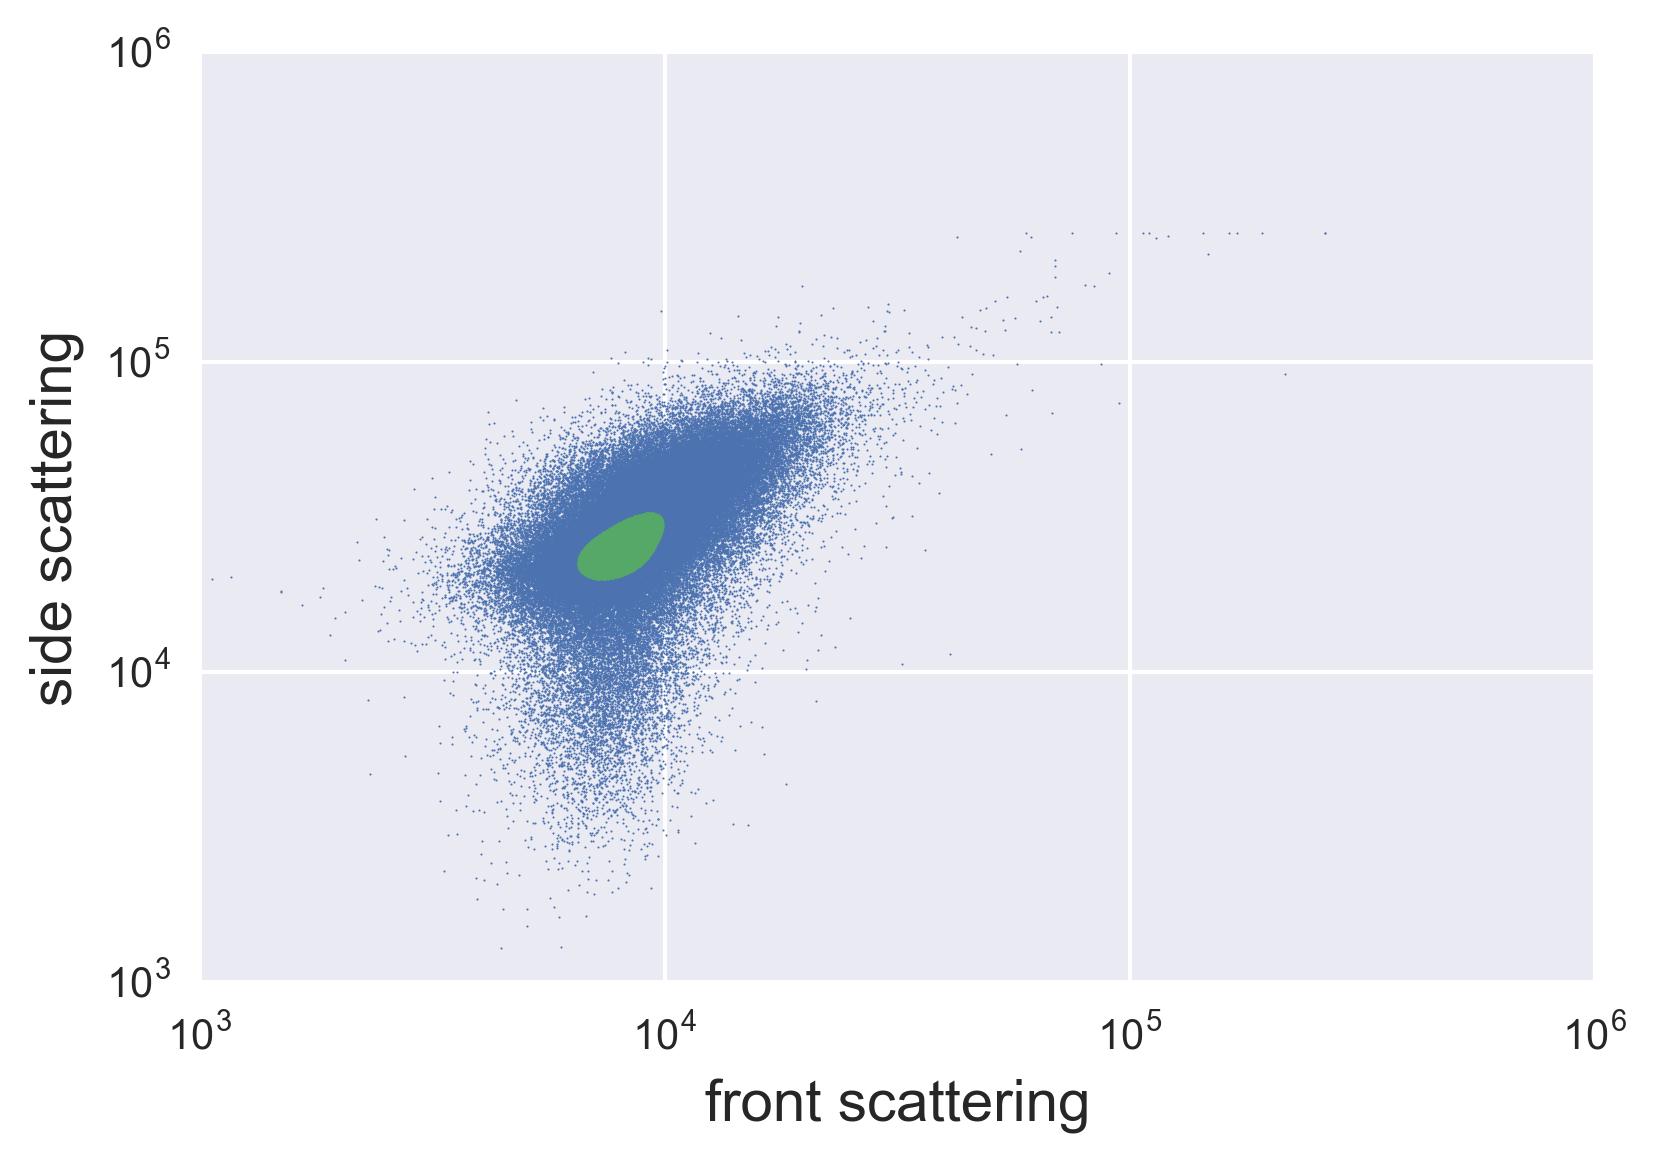

In [37]:
# Plot the excluded and included data
plt.loglog(fsc[~inds], ssc[~inds], '.', markersize=1, rasterized=True)
plt.loglog(fsc[inds], ssc[inds], '.', markersize=1, rasterized=True)
plt.xlabel('forward scattering')
plt.ylabel('side scattering');

We get a very similar result. So, the KDE method, and the histogram/contour method perform similarly (though it might be wise to do more tests). Given that the histogram/contour method is much much faster, we will stick with that one.

#### Performing the regression

Now that we have all the gating done, we can compute the mean fluorescence for all gated cells. First, we'll write a function to parse the file names to get the date, run number, strain, and IPTG concentration.

In [91]:
def parse_filename(fname):
    # Strip pre-directory and .csv suffix
    fname = os.path.split(fname)[-1][:-4]
    
    # Split at underscores to get fields
    fields = fname.split('_')
    
    # Return fields
    return int(fields[0]), int(fields[1]), fields[2], float(fields[3])

Now, we'll load in each data set and store the mean YFP intensity and other pertinent information in a nice, tidy, `DataFrame`.

In [38]:
# Set up DataFrame to store mean fluorescence
df_mean = pd.DataFrame(columns=['date', 'run', 'strain', 'iptg', 'yfp'],
                       index=np.arange(len(fnames)))

# Go through each file and compute and store mean fluorescence
for i, f in enumerate(fnames):
    fields = list(parse_filename(f))
    df = pd.read_csv(f)
    mean_yfp = np.mean(df.loc[df['gate']==1, 'FITC-A'])
    fields.append(mean_yfp)
    df_mean.loc[i,:] = fields
    
# Take a look
df_mean.head()

date run strain iptg      yfp
0  20160804   0   auto    0  4776.12
1  20160804   0   auto  0.1   4797.3
2  20160804   0   auto    1   4797.3
3  20160804   0   auto   10  4380.77
4  20160804   0   auto  100   4243.6

As per Manuel's lab notes, we should exclude the sample at 250 µM IPTG taken on August 4, 2016. We cannot be sure it was measured correctly.

In [112]:
inds = (df_mean['date'] == 20160804) & (df_mean['iptg'] == 250.0)
df_mean.loc[inds, 'yfp'] = np.nan
df_mean = df_mean.dropna()

Now, to compute the fold change, we need to make a new `DataFrame`. For each date/run/IPTG combination, the fold change is

\begin{align}
F = \frac{I_\text{RBS1027} - I_\text{auto}}{I_\text{delta} - I_\text{auto}},
\end{align}

where $I_i$ refers to the integrated fluorescence intensity of strain $i$. We can quickly compute this using a `GroupBy` object.

In [113]:
def fold_change(group):
    """
    Compute fold change from group containing RBS1027,
    auto, and delta fluorescence.
    """
    auto = group.loc[group['strain']=='auto', 'yfp'].values[0]
    rbs = group.loc[group['strain']=='RBS1027', 'yfp'].values[0]
    delta = group.loc[group['strain']=='delta', 'yfp'].values[0]
    return (rbs - auto) / (delta - auto)

# Make GroupBy
gb = df_mean.groupby(['date', 'run', 'iptg'])

# Make fold change DataFrame
df_fc = gb.apply(fold_change).reset_index()
df_fc = df_fc.rename(columns={0: 'fold_change'})

# Take a look
df_fc.head()

date  run  iptg  fold_change
0  20160804    0   0.0    -0.015083
1  20160804    0   0.1    -0.000211
2  20160804    0   1.0    -0.000211
3  20160804    0   5.0     0.039131
4  20160804    0  10.0     0.086696

For convenience, we will add a column, 'trial' that corresponds to a unique date-run pair.

In [114]:
# Group by date/run pairs
my_gb = df_fc.groupby(['date', 'run'])

# Assign trial numbers
i = 0
for name, _ in my_gb:
    df_fc.loc[(df_fc['date']==name[0]) & (df_fc['run']==name[1]), 'trial'] = i
    i += 1

# Make sure trials are integers
df_fc['trial'] = df_fc['trial'].astype(int)

# Take a look
df_fc.head()

date  run  iptg  fold_change  trial
0  20160804    0   0.0    -0.015083      0
1  20160804    0   0.1    -0.000211      0
2  20160804    0   1.0    -0.000211      0
3  20160804    0   5.0     0.039131      0
4  20160804    0  10.0     0.086696      0

Now we can plot the results.

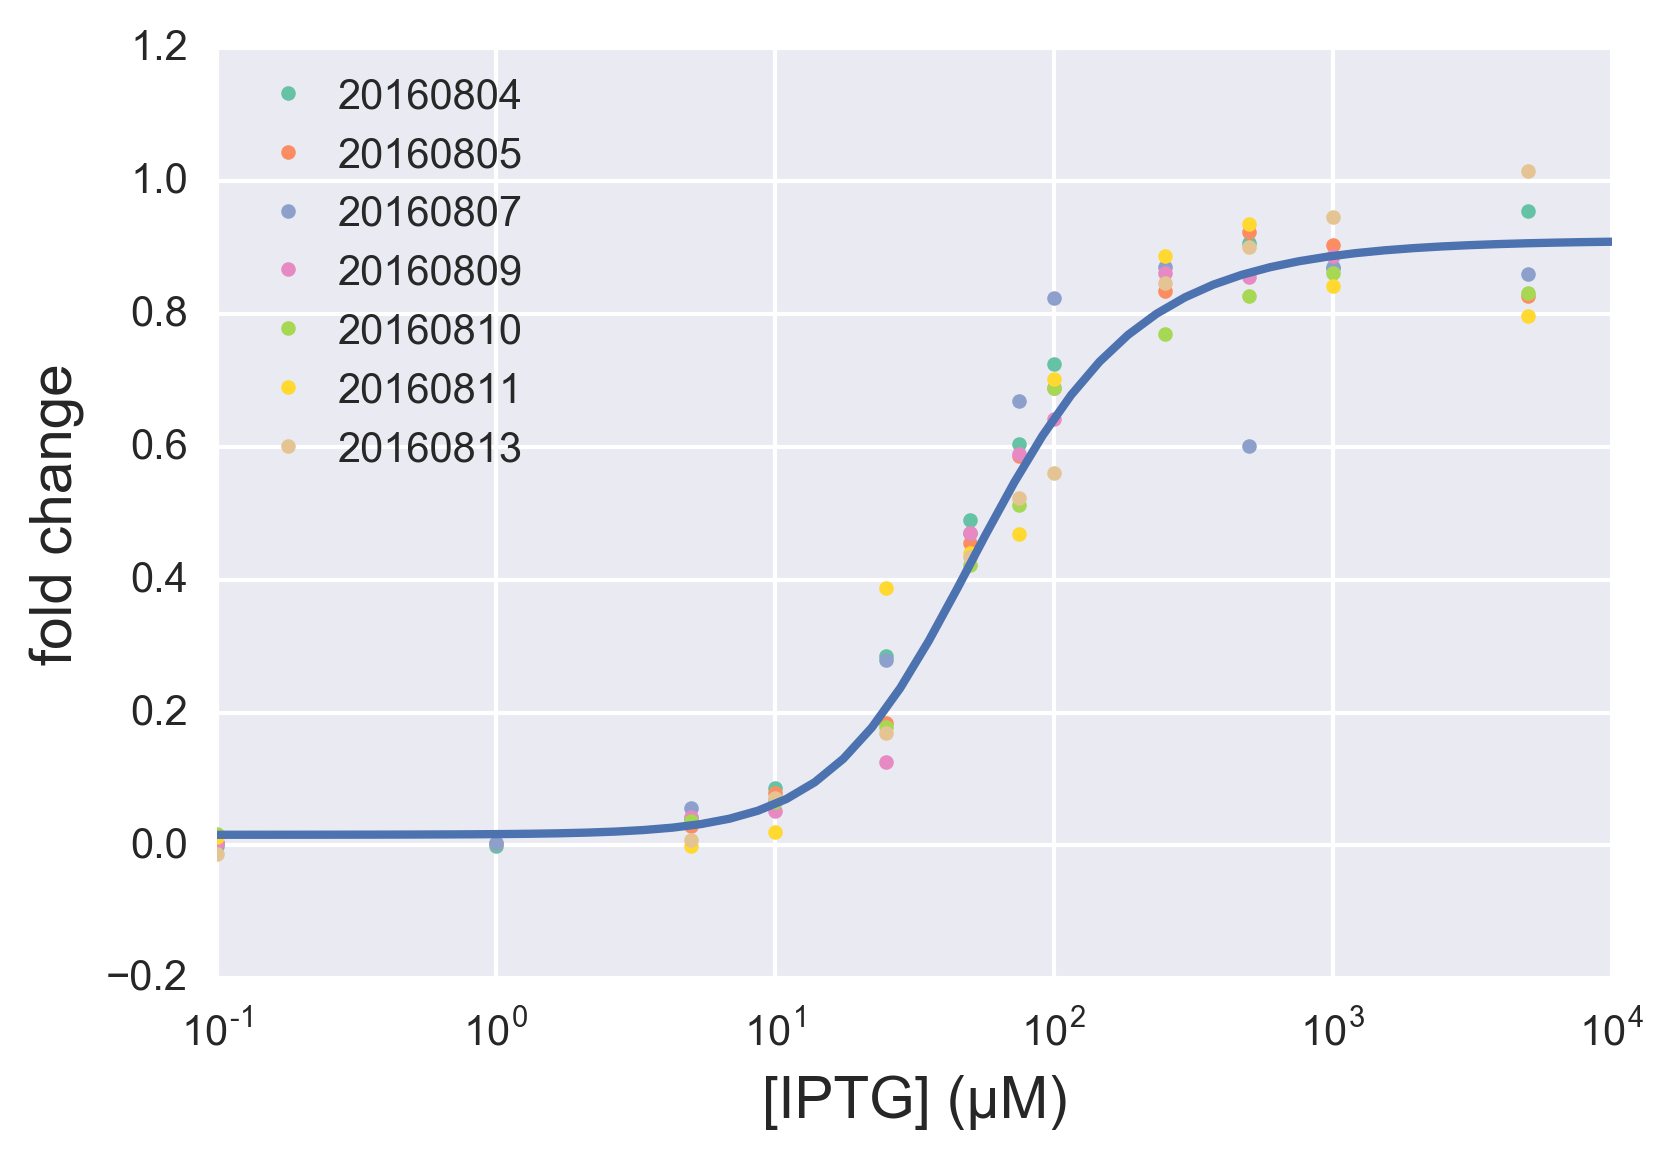

In [118]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
i = 0
for _, group in df_fc.groupby(['date', 'run']):
    plt.semilogx(group['iptg'], group['fold_change'], '.', 
                 label=group.date.iloc[0], color=colors[i])
    i += 1

plt.legend(loc='upper left')
plt.xlabel('[IPTG] (µM)')
plt.ylabel('fold change')

Now, let's try the regression.

In [166]:
@numba.jit(nopython=True)
def theor_fold_change(c, RKD, KAI, KA, KI):
    """
    Theoretical fold change.
    """
    num = (1 + c/KA)**2
    denom = num + KAI * (1 + c/KI)**2
    return 1 / (1 + num / denom * RKD)


@numba.jit(nopython=True)
def log_likelihood(p, c, F):
    """
    Log likelihood, assuming Cauchy distributed about theoretical curve.
    """
    # Unpack parameters
    RKD, KAI, KA, KI, beta, sigma_RKD, sigma_KAI = p

    # Theoretical curve
    fc = theor_fold_change(c, RKD, KAI, KA, KI)
    
    return -len(c) * np.log(beta) \
            - np.sum(np.log(1.0 + ((F - fc) / beta)**2))

    
@numba.jit(nopython=True)
def log_prior(p, RKD_prior, KAI_prior, sigma_RKD_min, sigma_RKD_max,
             sigma_KAI_min, sigma_KAI_max):
    """
    Log prior.
    """
    if np.any(p[:5] <= 0):
        return -np.inf
    
    # Unpack parameters
    RKD, KAI, KA, KI, beta, sigma_RKD, sigma_KAI = p
    
    # Make sure sigmas are in range
    if not (sigma_RKD_min < sigma_RKD < sigma_RKD_max):
        return -np.inf
    if not (sigma_KAI_min < sigma_KAI < sigma_KAI_max):
        return -np.inf
    
    # Jeffreys priors on uninformative priors
    lp = -np.log(beta) - np.log(KA) - np.log(KI) \
                - np.log(sigma_RKD) - np.log(sigma_KAI)
        
    # Informative priors
    lp -= np.log(sigma_RKD) + (RKD - RKD_prior)**2 / 2 / sigma_RKD**2
    lp -= np.log(sigma_KAI) + (KAI - KAI_prior)**2 / 2 / sigma_KAI**2

    return lp


@numba.jit(nopython=True)
def log_posterior(p, c, F, RKD_prior, KAI_prior, sigma_RKD_min, sigma_RKD_max,
             sigma_KAI_min, sigma_KAI_max):
    """
    Log posterior.
    """
    lp = log_prior(p, RKD_prior, KAI_prior, sigma_RKD_min, sigma_RKD_max,
                   sigma_KAI_min, sigma_KAI_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(p, c, F)

In [171]:
# Seed random number generator for reproducibility
np.random.seed(42)

# Define prior parameter values
RKD_prior = 2 * 130 / 4.2
KAI_prior = 0.01
sigma_RKD_min = RKD_prior * 0.001
sigma_RKD_max = RKD_prior * 1.2
sigma_KAI_min = KAI_prior * 0.001
sigma_KAI_max = KAI_prior * 1.2

# Set up parameters
p_dict = collections.OrderedDict(
        [('RKD', (np.random.uniform, (RKD_prior*0.9, RKD_prior*1.1))),
         ('KAI', (np.random.uniform, (KAI_prior*0.9, KAI_prior*1.1))),
         ('KA', (np.random.uniform, (100, 200))),
         ('KI', (np.random.uniform, (0.1, 1))),
         ('beta', (np.random.exponential, (1,))),
         ('sigma_RKD', (np.random.uniform, (sigma_RKD_min, sigma_RKD_max))),
         ('sigma_KAI', (np.random.uniform, (sigma_KAI_min, sigma_KAI_max)))])

# Run MCMC
args=(df_fc['iptg'].values, df_fc['fold_change'].values, RKD_prior, KAI_prior,
      sigma_RKD_min, sigma_RKD_max, sigma_KAI_min, sigma_KAI_max)
df_mcmc = bebi103.run_ensemble_emcee(
    log_posterior, p_dict=p_dict, args=args, n_walkers=50, 
    n_burn=500000, n_steps=50000)

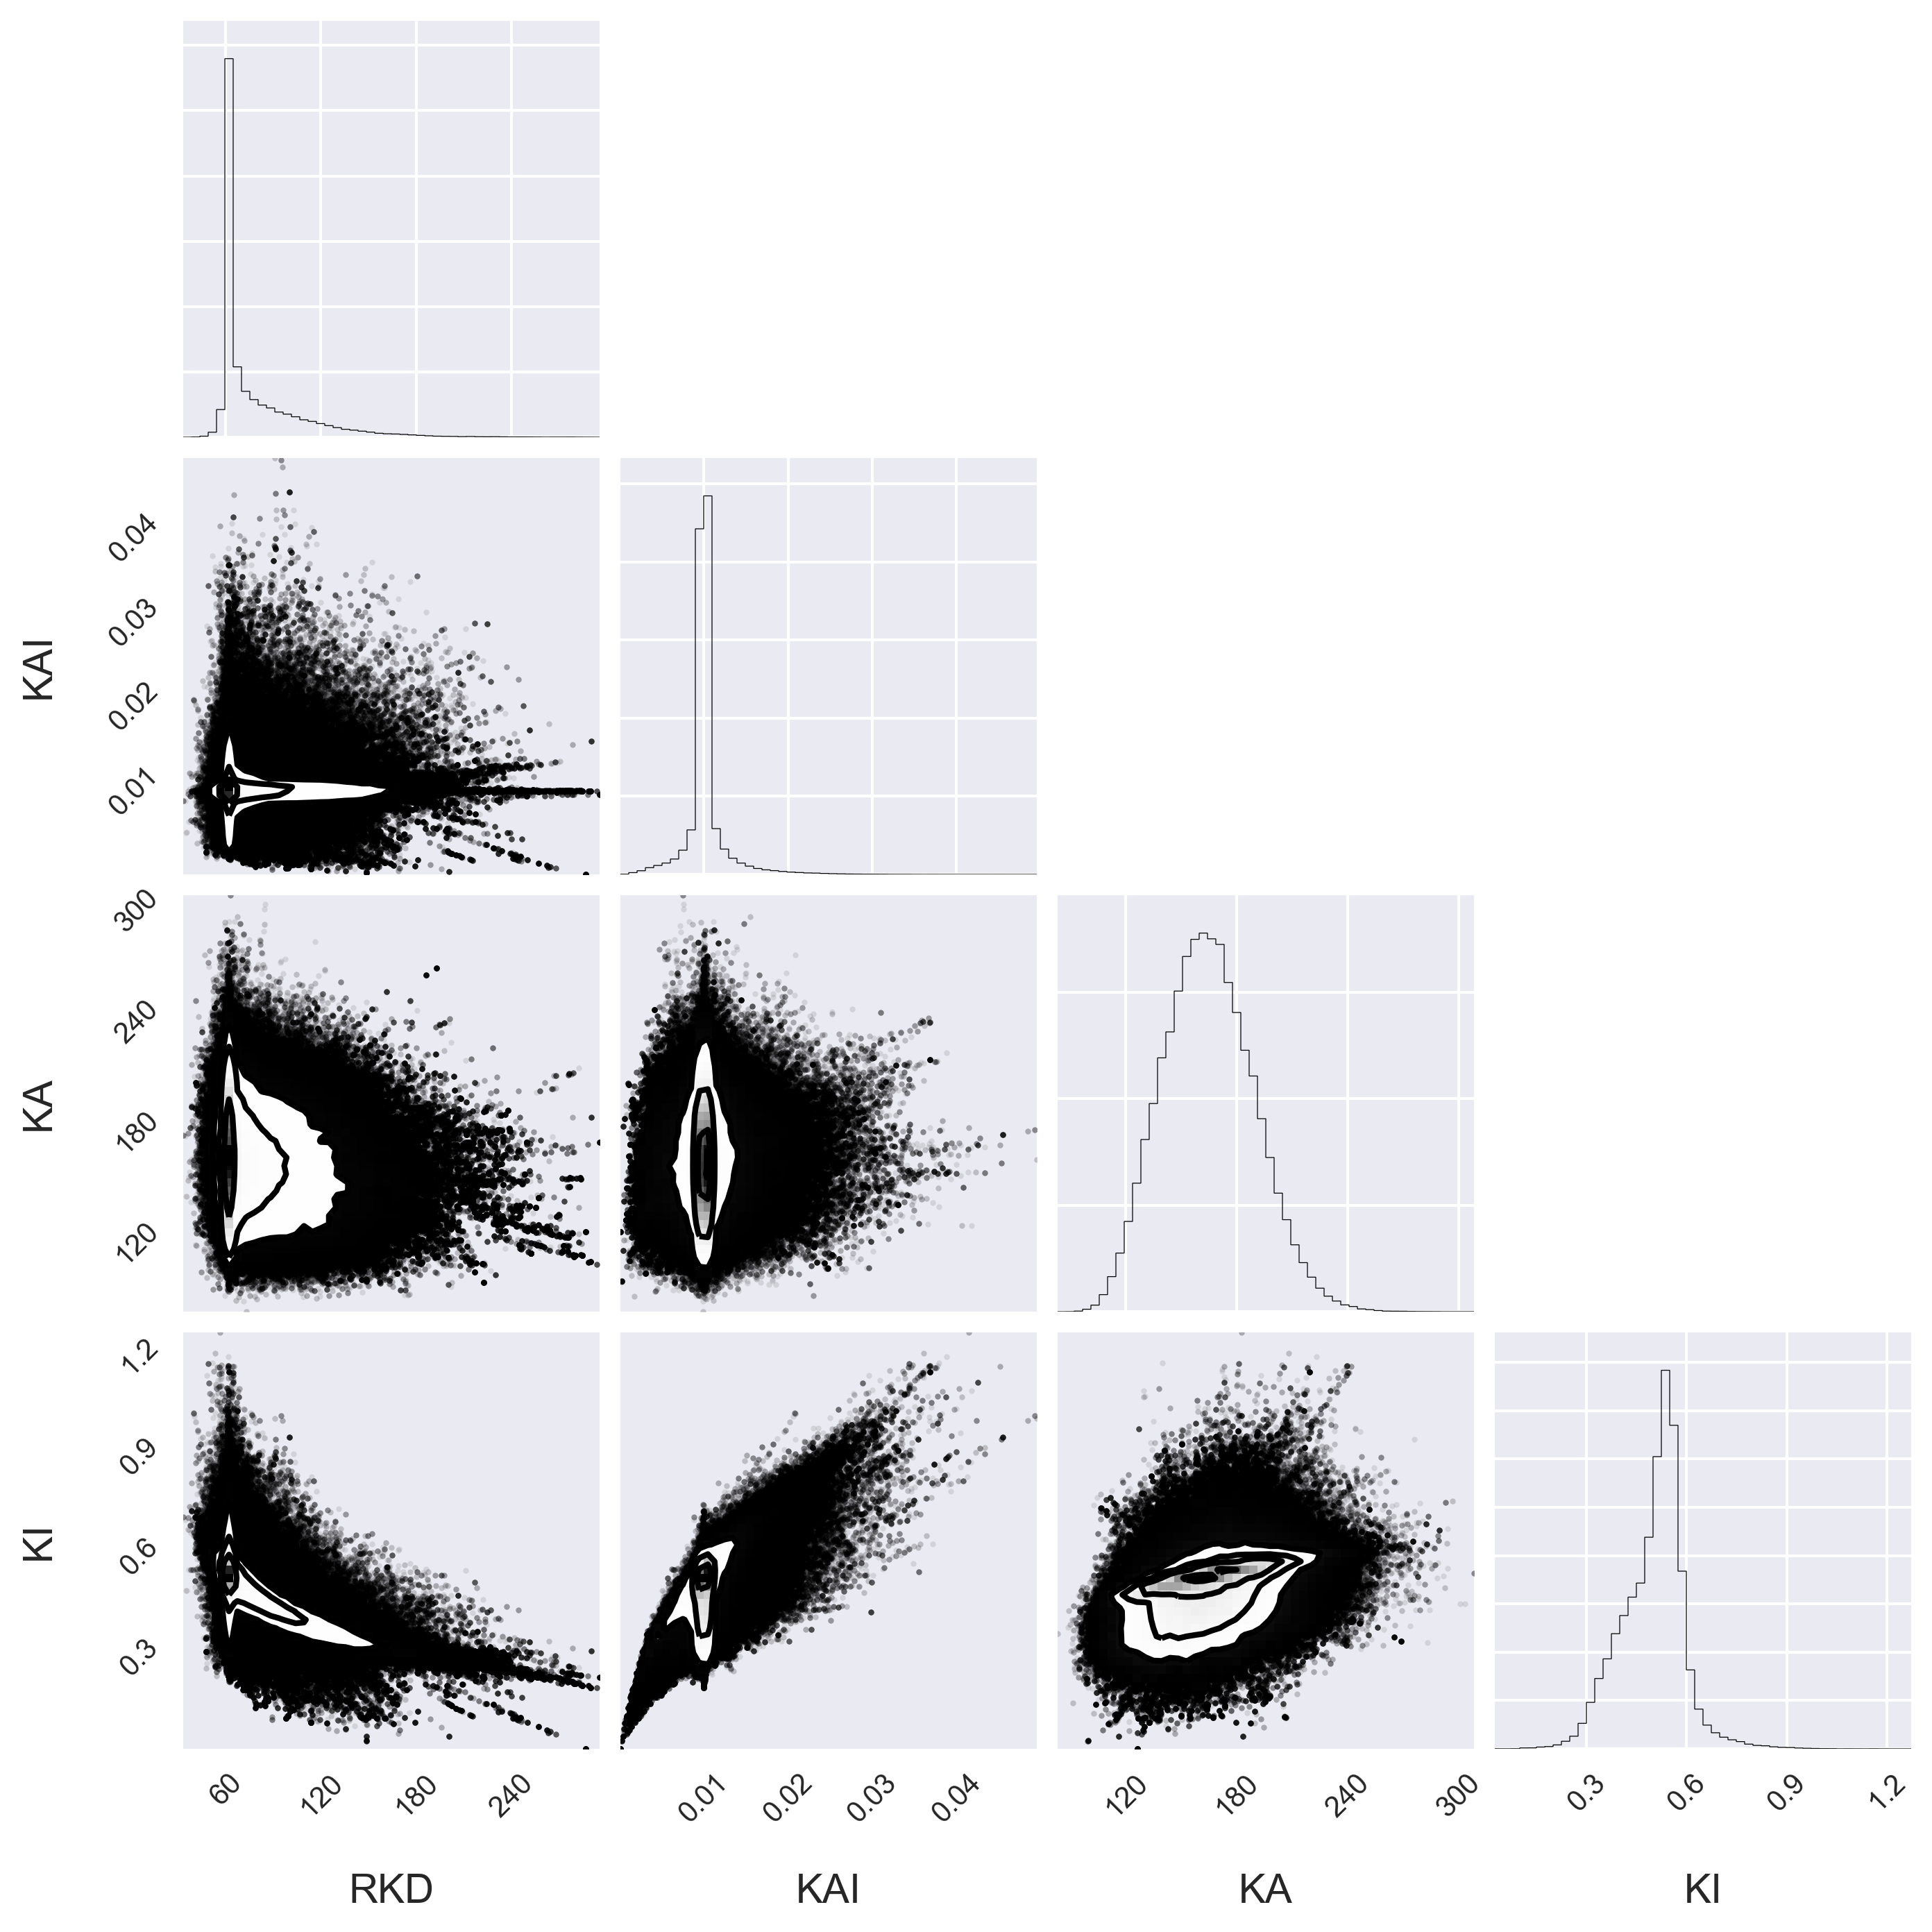

In [172]:
corner.corner(df_mcmc[['RKD', 'KAI', 'KA', 'KI']], 
              labels=['RKD', 'KAI', 'KA', 'KI'], bins=50);

Compute the modes and HPDs of the relevant parameters.

In [177]:
df_hpd = pd.DataFrame(columns=['RKD', 'KAI', 'KA', 'KI'],
                      index=['HPD_min', 'HPD_max', 'mode'])
most_prob_ind = np.argmax(df_mcmc['lnprob'])
for param in df_hpd.columns:
    hpd_min, hpd_max = bebi103.hpd(df_mcmc[param], 0.95)
    mode = df_mcmc.loc[most_prob_ind, param]
    df_hpd.loc[['HPD_min', 'HPD_max', 'mode'], param] = [hpd_min, hpd_max, mode]

df_hpd

RKD         KAI       KA        KI
HPD_min   52.892  0.00447196  117.581  0.285225
HPD_max  143.738   0.0153441  212.461  0.651733
mode     61.9281   0.0100003  164.908  0.547084